In [1]:
from hdbcli import dbapi
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px


from functools import reduce

from datetime import datetime
import datetime

pd.set_option('display.max_columns', None)

load_dotenv()

False

In [2]:
serverAdress_prod='vp55db01.sce.com' 
serverPort_prod=30015 
userName_prod = 'LINZ'
passWord_prod = 'Gravel$180'
#userName_prod=os.getenv('USER') 
#passWord_prod=os.getenv('PASSWORD') 

# Connect to hana database
try:
    cnn = dbapi.connect(serverAdress_prod,serverPort_prod,userName_prod,passWord_prod) 
    print('SAP connection established')
    cursor_prod=cnn.cursor() 
except Exception as e:
    print(f'ERROR: {e}')

SAP connection established


In [3]:
import vertexai
from snowflake.snowpark import Session
from snowflake.connector.pandas_tools import write_pandas

from google.cloud import secretmanager
from google.cloud import aiplatform
from google.cloud import storage
import json
import time

def access_secret_version(project_id, secret_id, version_id="latest"):
    client = secretmanager.SecretManagerServiceClient()
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"

    response = client.access_secret_version(request={"name": name})
    payload = response.payload.data.decode("UTF-8")
    return payload

/opt/conda/lib/python3.10/site-packages/snowflake/connector/options.py:104: UserWarning: You have an incompatible version of 'pyarrow' installed (20.0.0), please install a version that adheres to: 'pyarrow<19.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [4]:
path_name='gs://ebill_enrollment_model/implementation_20250821'

from datetime import date

cutoff_date=date.today()
print(cutoff_date)

2025-09-11


In [5]:
from datetime import datetime

formatted_date=cutoff_date.strftime('%Y%m%d')

print(formatted_date)

20250911


## Part 1 - E-Bill enrollment

#### 1.1 - all active residential customers as of the cutoff date
* Move Out date >= cutoff date
* Move In date < cutoff date

In [6]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

     SELECT DISTINCT MD."0CACONT_ACC" AS cact,
       MD."0BBP_BUYID" as bp,
       MD."ZPLITEAL" as rate_plan,
       MD."0UCRATE_CAT" as rate_plan_cat,
       case when "ZHAUSNUM" is null or "4ZMD_A008_HOUSE_NUM2" is null then 0 else 1 end as unit_num, 
       case when "ZLANDLINE" is null then 0 else 1 end as landline, 
       case when "ZMOBILENU" is null then 0 else 1 end as mobilephone,
       case when "ZTELNUM" is null then 0 else 1 end as having_phone, 
       "CC_CUSTOMER_TYPE_D" as cust_type, 
       "CC_CRITICAL_CARE_FLAG" as critical_care, 
      MD."0UCCONTRACT" as cactnum,
      to_date(MD."0UCMOVEIN_D") as movein_date,
      to_date(MD."0UCMOVEOUTD") as moveout_date,
      MD."ZSCTRL_GP" as bill_type, 
      case when MD."0EMAIL_ADDR" like '%@%' then 1 else 0 end as have_email
      FROM _SYS_BIC."sce.cs.md.core/CV_UTILITIES_MASTER" as MD
      WHERE MD."0UCACC_CLAS"='RESI' 
      and to_date(MD."0UCMOVEOUTD") >= cutoff_date 
      and to_date(MD."0UCMOVEIN_D") < cutoff_date;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f48d3fc41c0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [7]:
all_resi_model=pd.DataFrame(ret)
all_resi_model.columns=['cact', 'bp', 'rate_plan', 'rate_plan_cat', 'unit_num', 'landline',
                        'mobilephone', 'having_phone', 'cust_type', 'critical_care', 
                        'cactnum', 'movein_date', 'moveoutdate', 'bill_type', 'have_email'] 
all_resi_model.info()
all_resi_model.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687991 entries, 0 to 4687990
Data columns (total 15 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cact           object
 1   bp             object
 2   rate_plan      object
 3   rate_plan_cat  object
 4   unit_num       int64 
 5   landline       int64 
 6   mobilephone    int64 
 7   having_phone   int64 
 8   cust_type      object
 9   critical_care  object
 10  cactnum        object
 11  movein_date    object
 12  moveoutdate    object
 13  bill_type      object
 14  have_email     int64 
dtypes: int64(5), object(10)
memory usage: 536.5+ MB


,cact,bp,rate_plan,rate_plan_cat,unit_num,landline,mobilephone,having_phone,cust_type,critical_care,cactnum,movein_date,moveoutdate,bill_type,have_email
0,700779840537,1007233698,TOU-D-PRIME,TDPRIME,1,1,1,1,Domestic,None,8015027955,2023-01-17,9999-12-31,CHKF,1
1,700244070131,1003653949,TOUD-5-8PM,TD58,1,1,1,1,Domestic,No,8000136883,2021-03-12,9999-12-31,HCB,1
2,700037362121,1003652821,TOUD-5-8PM,TD58,1,1,1,1,Domestic,None,8004917847,2021-03-21,9999-12-31,HCB,0
3,700421026322,1004385842,D-CARE-SDP,D,1,1,1,1,Domestic,None,8001599169,2021-03-11,9999-12-31,EBIL,1
4,700429250710,1001016596,DOMESTIC,D,1,1,1,1,Domestic,No,8003826606,2021-03-23,9999-12-31,HCB,1


In [8]:
all_resi_model['have_email'].mean()

np.float64(0.8326784330430669)

In [10]:
all_resi_model.to_csv(str(path_name)+str('/all_resi_model.csv'), index=False)

#### 1. 2 - all customers with email as of cutoff date
* Emails from MyAccount and contact table will be pulled.

In [11]:
# email from CV_CONSENT_GUID_WEBID (for MyAccount)
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

     select ZMOBJKEY as cact,
     "0BPARTNER" as bp,
     "0VALIDFROM___T" as email_valid_from,
     "0VALIDTO___T" as email_valid_to,
      EMAIL
     from "_SYS_BIC"."sce.cs.id.core/CV_CONSENT_GUID_WEBID"
     where to_date("0VALIDTO___T") >= cutoff_date
       and to_date("0VALIDFROM___T") < cutoff_date
      and email like '%@%';
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [12]:
email_myacct=pd.DataFrame(ret)
email_myacct.columns=['cact', 'bp', 'email_valid_from', 'email_valid_to', 'email'] 
email_myacct.info()
email_myacct.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6407129 entries, 0 to 6407128
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   cact              object
 1   bp                object
 2   email_valid_from  object
 3   email_valid_to    object
 4   email             object
dtypes: object(5)
memory usage: 244.4+ MB


,cact,bp,email_valid_from,email_valid_to,email
0,700903279707,1008178145,2024-07-10,9999-12-31,Jazziedadoll@gmail.com
1,700898300876,1008142811,2024-07-12,9999-12-31,rochellemoss10@gmail.com
2,700915049544,1008142811,2024-08-21,9999-12-31,rochellemoss10@gmail.com
3,700903043166,1008176319,2024-07-09,9999-12-31,valhuizar10@gmail.com
4,700903911520,1008182365,2024-07-12,9999-12-31,deliaolmos95@gmail.com


In [13]:
email_myacct.to_csv(str(path_name)+str('/email_myacct.csv'), index=False)

In [14]:
# email from SV_BP_CONTACT_DETAILS
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

     SELECT
          Table__1."0BPARTNER" AS BP, 
          Table__1."ZCOMM_VALIDFRM", 
          Table__1."ZCOMM_VALIDTO",  
          Table__1."ZSMTP_AD" AS BP_EMAIL, 
          Table__1."ZEMAIL_DEFAULT_FROM", 
          Table__1."ZEMAIL_DEFAULT_TO" 
     FROM "_SYS_BIC"."sce.cs.cim.sem/SV_BP_CONTACT_DETAILS"  Table__1
     WHERE Table__1."ZSTATUSC" IN ('EMAIL')
       AND Table__1."ZSMTP_AD" IS NOT NULL
       AND to_date(Table__1."ZCOMM_VALIDTO") >= cutoff_date 
       and to_date(Table__1."ZCOMM_VALIDFRM") < cutoff_date 
       AND Table__1."ZCOMM_VALIDFRM" IS NOT NULL
       AND Table__1."ZSMTP_AD" like '%@%';
     end;
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [15]:
email_contact=pd.DataFrame(ret)
email_contact.columns=['bp', 'ZCOMM_VALIDFRM', 'ZCOMM_VALIDTO', 'bp_email', 'email_contact_from',
                       'email_contact_to']
email_contact.info()
email_contact.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10622574 entries, 0 to 10622573
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   bp                  object
 1   ZCOMM_VALIDFRM      object
 2   ZCOMM_VALIDTO       object
 3   bp_email            object
 4   email_contact_from  object
 5   email_contact_to    object
dtypes: object(6)
memory usage: 486.3+ MB


,bp,ZCOMM_VALIDFRM,ZCOMM_VALIDTO,bp_email,email_contact_from,email_contact_to
0,1007030344,2022-09-10,9999-12-31,nytshop@verizon.net,2022-09-10,2023-01-01
1,1001427225,2021-04-01,9999-12-31,KAMALISRI@YAHOO.COM,None,None
2,1005637954,2021-12-29,9999-12-31,INGREEDJEE@HOTMAIL.COM,2021-12-29,9999-12-31
3,1002973606,2010-11-19,9999-12-31,ABEER.ABDELRAHIM@YAHOO.COM,2010-11-19,9999-12-31
4,1006776393,2022-05-05,9999-12-31,imshuangzhang@hotmail.com,2022-05-05,9999-12-31


In [16]:
email_contact.to_csv(str(path_name)+str('/email_contact.csv'), index=False)

#### 1.3 - Customers who have enrolled or opted out in the past (by cutoff date)

In [110]:
# notice we use 2025-02-01 as the cutoff data for enrollment
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-09-08';

    SELECT 
            ZOBJTID as cact,
            max(to_date(ZUDATE___T))    as last_enroll_date,
            min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_enroll_recency, 
            count(ZVALUEOLD) as enroll_cnt_total
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as enroll_cnt_lastyear,
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as enroll_cnt_last2years 
        FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUENEW = 'EBIL'
            and to_date(ZUDATE___T) < cutoff_date
        group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

(257, 'sql syntax error: incorrect syntax near "sum": line 10 col 13 (at pos 306)')


In [111]:
past_enroll=pd.DataFrame(ret)
past_enroll.columns=['cact', 'past_enroll_date', 'past_enroll_recency', 'enroll_cnt_total', 'enroll_cnt_lastyear', 'enroll_cnt_last2years']
past_enroll.info()
past_enroll.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894420 entries, 0 to 894419
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   894420 non-null  object
 1   past_enroll_date       894420 non-null  object
 2   past_enroll_recency    894420 non-null  int64 
 3   enroll_cnt_total       894420 non-null  int64 
 4   enroll_cnt_lastyear    894420 non-null  int64 
 5   enroll_cnt_last2years  894420 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 40.9+ MB


,cact,past_enroll_date,past_enroll_recency,enroll_cnt_total,enroll_cnt_lastyear,enroll_cnt_last2years
0,700291241837,2022-10-03,1071,1,0,0
1,700871320530,2025-07-10,60,1,1,1
2,700005867635,2025-01-31,220,1,1,1
3,700928219821,2025-08-03,36,2,2,2
4,700171756227,2023-06-24,807,1,0,0


In [112]:
past_enroll.to_csv(str(path_name)+str('/past_enroll.csv'), index=False)

In [6]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-09-08';

    SELECT ZOBJTID as cact,
                   max(to_date(ZUDATE___T)) as latest_optout_date, 
                   min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_optout_recency, 
                   count(ZVALUEOLD) as optout_cnt_total,
                   sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as optout_cnt_lastyear,
                   sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as optout_cnt_last2years 
            FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUEOLD = 'EBIL'
              and to_date(ZUDATE___T) < cutoff_date
       group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [7]:
past_optout=pd.DataFrame(ret)
past_optout.columns=['cact', 'latest_optout_date', 'last_optout_recency','optout_cnt_total', 'optout_cnt_lastyear', 'optout_cnt_last2years']
past_optout.info()
past_optout.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894420 entries, 0 to 894419
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   894420 non-null  object
 1   latest_optout_date     894420 non-null  object
 2   last_optout_recency    894420 non-null  int64 
 3   optout_cnt_total       894420 non-null  int64 
 4   optout_cnt_lastyear    894420 non-null  int64 
 5   optout_cnt_last2years  894420 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 40.9+ MB


,cact,latest_optout_date,last_optout_recency,optout_cnt_total,optout_cnt_lastyear,optout_cnt_last2years
0,700291241837,2022-10-03,1071,1,0,0
1,700871320530,2025-07-10,60,1,1,1
2,700005867635,2025-01-31,220,1,1,1
3,700928219821,2025-08-03,36,2,2,2
4,700171756227,2023-06-24,807,1,0,0


In [8]:
print(past_optout['latest_optout_date'].min())
print(past_optout['latest_optout_date'].max())

2021-04-06
2025-09-07


In [9]:
past_optout.to_csv(str(path_name)+str('/past_optout.csv'), index=False)

#### 1.4 - GOV, SR. Citizen, Bankruptcy, Disaster Relief & Redlist

In [24]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

SELECT DISTINCT  
          t1.*
      FROM _SYS_BIC."system-local.bw.bw2hana/ZMD_A040" t1
      WHERE "0BP_ID_TYPE" IN ('ZFED','ZOTH','ZSTA','ZCIT','ZCOU', 'ZBAN', 'ZSRC', 'ZDIS', 'ZCAS') 
      AND to_date("0DATETO___T") >= cutoff_date
      AND to_date("0DATEFROM___T") <= cutoff_date;
end; 
'''

In [25]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [26]:
excl_exempt=pd.DataFrame(ret)
excl_exempt.columns=['0BP_ID_DATE',
'0BP_ID_NUM',
'0BP_ID_TYPE',
'0BP_ID_TYPE___T',
'0COUNTRY',
'0COUNTRY___T',
'0DATEFROM',
'0DATETO',
'0FLGDELETED',
'0REGION',
'0REGION___T',
'0REQTSN',
'0TIME',
'0UPD_DATE',
'ZBP_PART',
'ZBP_PART___T',
'ZINSTITUT',
'0BP_ID_DATE___T',
'0DATEFROM___T',
'0DATETO___T',
'0TIME___T',
'0UPD_DATE___T',
'__AP_CHECK_INT',
'1ROWCOUNT']
excl_exempt.info()
excl_exempt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412542 entries, 0 to 412541
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   0BP_ID_DATE      412542 non-null  object
 1   0BP_ID_NUM       412542 non-null  object
 2   0BP_ID_TYPE      412542 non-null  object
 3   0BP_ID_TYPE___T  412542 non-null  object
 4   0COUNTRY         412542 non-null  object
 5   0COUNTRY___T     142201 non-null  object
 6   0DATEFROM        412542 non-null  object
 7   0DATETO          412542 non-null  object
 8   0FLGDELETED      412542 non-null  object
 9   0REGION          412542 non-null  object
 10  0REGION___T      2283 non-null    object
 11  0REQTSN          412542 non-null  object
 12  0TIME            412542 non-null  object
 13  0UPD_DATE        412542 non-null  object
 14  ZBP_PART         412542 non-null  object
 15  ZBP_PART___T     412542 non-null  object
 16  ZINSTITUT        412542 non-null  object
 17  0BP_ID_DAT

,0BP_ID_DATE,0BP_ID_NUM,0BP_ID_TYPE,0BP_ID_TYPE___T,0COUNTRY,0COUNTRY___T,0DATEFROM,0DATETO,0FLGDELETED,0REGION,0REGION___T,0REQTSN,0TIME,0UPD_DATE,ZBP_PART,ZBP_PART___T,ZINSTITUT,0BP_ID_DATE___T,0DATEFROM___T,0DATETO___T,0TIME___T,0UPD_DATE___T,__AP_CHECK_INT,1ROWCOUNT
0,20250403,MOUNTAIN FIRE,ZDIS,Disaster Relief,,None,20241106,20251107,,,None,00000000000000000000000,203912,20250907,1005696477,KRISTINE HACOBIAN,,2025-04-03,2024-11-06,2025-11-07,20:39:12,2025-09-07,1,1
1,20250504,8004032577_BOT_201222,ZSRC,Sr Citizen Occupant,,None,20250504,99991231,,,None,00000000000000000000000,203907,20250907,1003379479,JAMES HOWARTH,,2025-05-04,2025-05-04,9999-12-31,20:39:07,2025-09-07,1,1
2,20250325,X,ZSRC,Sr Citizen Occupant,,None,20250325,99991231,,,None,00000000000000000000000,203913,20250907,1004964206,CHARLES MOORE,,2025-03-25,2025-03-25,9999-12-31,20:39:13,2025-09-07,1,1
3,00000000,001,ZCAS,Cash ONLY,,None,20250829,20260225,,,None,00000000000000000000000,203915,20250907,1004222495,GEZABEL OLIVARES,,None,2025-08-29,2026-02-25,20:39:15,2025-09-07,1,1
4,00000000,JANUARY 2025 WIND AND FIRE STORMS,ZDIS,Disaster Relief,,None,20250107,20260108,,,None,00000000000000000000000,203913,20250907,1005810125,L FOWLES,,None,2025-01-07,2026-01-08,20:39:13,2025-09-07,1,1


In [27]:
excl_exempt.to_csv(str(path_name)+str('/excl_exempt.csv'), index=False)

#### 1.5 - DE rate

In [28]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

SELECT DISTINCT 
          t1."0UCINSTALLA" AS INSTALLATION,
          t1."0UCOPERAND" AS EMPL,
          t1."0DATEFROM___T" AS EMPL_DATEFROM, 
          t1."0DATETO___T" AS EMPL_DATETO

      FROM _SYS_BIC."system-local.bw.bw2hana/ZUB_A006" t1 
        WHERE t1."0UCOPERAND" IN ('EFL-EMPL','GFL-EMPL')
        AND to_date(t1."0DATETO___T") >= current_date;
end; 
'''

In [29]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [30]:
de=pd.DataFrame(ret)
de.columns=['INSTALLATION', 'EMPL', 'MPL_DATEFROM', 'EMPL_DATETO']
de.info()
de.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14452 entries, 0 to 14451
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   INSTALLATION  14452 non-null  object
 1   EMPL          14452 non-null  object
 2   MPL_DATEFROM  14452 non-null  object
 3   EMPL_DATETO   14452 non-null  object
dtypes: object(4)
memory usage: 451.8+ KB


,INSTALLATION,EMPL,MPL_DATEFROM,EMPL_DATETO
0,0905461462,EFL-EMPL,2023-08-08,9999-12-31
1,0902112549,EFL-EMPL,2009-04-03,9999-12-31
2,0904091559,EFL-EMPL,2016-07-21,9999-12-31
3,0901021236,EFL-EMPL,1993-03-23,9999-12-31
4,0900665721,EFL-EMPL,2020-09-15,9999-12-31


In [31]:
excl_de=de.sort_values(by=['INSTALLATION', 'EMPL_DATETO'], ascending=True)
excl_de.drop_duplicates(subset='INSTALLATION', keep='first')
excl_de.shape

(14452, 4)

In [32]:
excl_de.to_csv(str(path_name)+str('/excl_de.csv'), index=False)

#### 1.6 - Customers with payment within 1 year

In [33]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          max(to_date(t1."0CLEAR_DATE___T")) AS LAST_PYMT_DATE
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."4ZFI_A026_ZZCBLART" IN ('DP','HB','I1','J1','J2','J4','J5','J6','J7','QC') 
        AND t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -365) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC"  like '7%'
        group by "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

In [34]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [35]:
excl_payment_1yr=pd.DataFrame(ret)
excl_payment_1yr.columns=['cact', 'pymt_type', 'last_pymt_date']
excl_payment_1yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4121526 entries, 0 to 4121525
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   cact            object
 1   pymt_type       object
 2   last_pymt_date  object
dtypes: object(3)
memory usage: 94.3+ MB


In [36]:
excl_payment_1yr['last_pymt_date']=pd.to_datetime(excl_payment_1yr['last_pymt_date'], errors='coerce')
excl_payment_1yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4121526 entries, 0 to 4121525
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   cact            object        
 1   pymt_type       object        
 2   last_pymt_date  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 94.3+ MB


In [37]:
# aggregate payment method information
excl_payment_1yr['cact'].nunique()

3595647

In [38]:
# last payment type
excl_payment_1yr.sort_values(by=['cact', 'last_pymt_date'], ascending=False, inplace=True)
excl_payment_1yr.drop_duplicates(subset=['cact', 'last_pymt_date'], keep='first', inplace=True)
excl_payment_1yr['last_payment_recency']=(pd.to_datetime('2025-01-01')-excl_payment_1yr['last_pymt_date']).dt.days
excl_payment_1yr.head()

,cact,pymt_type,last_pymt_date,last_payment_recency
1229296,701001568490,J2,2025-09-05,-247
3680312,701001441380,J2,2025-09-05,-247
1267503,701001381665,J2,2025-09-03,-245
3046966,701001057929,J2,2025-09-04,-246
1318437,701001049542,I1,2025-09-06,-248


In [39]:
excl_payment_1yr.to_csv(str(path_name)+str('/excl_payment_1yr.csv'), index=False)

#### 1.7 - payment types in last year

In [40]:
# past 30 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -30) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC"  like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

In [41]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [42]:
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8686407 entries, 0 to 8686406
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   cact       object
 1   pymt_type  object
 2   pymt_ct    int64 
dtypes: int64(1), object(2)
memory usage: 198.8+ MB


In [43]:
payment_30=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_30.columns=['count_'+str(col)+'_30' for col in payment_30.columns]
payment_30.fillna(0, inplace=True)

payment_30.head()

,count_AM_30,count_CP_30,count_CS_30,count_DP_30,count_ED_30,count_EF_30,count_ER_30,count_HB_30,count_HP_30,count_I1_30,count_IB_30,count_IN_30,count_IR_30,count_J1_30,count_J2_30,count_J4_30,count_J5_30,count_J6_30,count_J7_30,count_ML_30,count_MP_30,count_QC_30,count_RF_30,count_S1_30,count_S2_30,count_S4_30,count_TP_30,count_W1_30,count_WO_30,count_WT_30
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# past 60 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -60) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']

payment_60=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_60.columns=['count_'+str(col)+'_60' for col in payment_60.columns]
payment_60.fillna(0, inplace=True)

payment_60.head()

,count_AM_60,count_CP_60,count_CS_60,count_DP_60,count_ED_60,count_EF_60,count_ER_60,count_HB_60,count_HP_60,count_I1_60,count_IB_60,count_IN_60,count_IR_60,count_J1_60,count_J2_60,count_J4_60,count_J5_60,count_J6_60,count_J7_60,count_ML_60,count_MP_60,count_QC_60,count_RE_60,count_RF_60,count_S1_60,count_S2_60,count_S4_60,count_TP_60,count_W1_60,count_WO_60,count_WT_60
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# past 90 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -90) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end;
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']

payment_90=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_90.columns=['count_'+str(col)+'_90' for col in payment_90.columns]
payment_90.fillna(0, inplace=True)

payment_90.head()

,count_AM_90,count_CP_90,count_CS_90,count_DP_90,count_ED_90,count_EF_90,count_ER_90,count_HB_90,count_HP_90,count_I1_90,count_IB_90,count_IN_90,count_IR_90,count_J1_90,count_J2_90,count_J4_90,count_J5_90,count_J6_90,count_J7_90,count_ML_90,count_MP_90,count_QC_90,count_RE_90,count_RF_90,count_S1_90,count_S2_90,count_S4_90,count_TP_90,count_W1_90,count_WO_90,count_WT_90
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# past 180 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -180) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']

payment_180=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_180.columns=['count_'+str(col)+'_180' for col in payment_180.columns]
payment_180.fillna(0, inplace=True)

payment_180.head()

,count_AM_180,count_CP_180,count_CS_180,count_DP_180,count_ED_180,count_EF_180,count_ER_180,count_HB_180,count_HP_180,count_I1_180,count_IB_180,count_IN_180,count_IR_180,count_J1_180,count_J2_180,count_J4_180,count_J5_180,count_J6_180,count_J7_180,count_ML_180,count_MP_180,count_QC_180,count_RE_180,count_RF_180,count_S1_180,count_S2_180,count_S4_180,count_TP_180,count_W1_180,count_WO_180,count_WT_180
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# past 360 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count,       
          min(days_between(to_date(t1."0CLEAR_DATE___T"), cutoff_date)) as payment_recency 
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -365) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct', 'pymt_type_recency']

payment_360=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_360.columns=['count_'+str(col)+'_360' for col in payment_360.columns]
payment_360.fillna(0, inplace=True)

payment_360.head()

,count_AM_360,count_CP_360,count_CS_360,count_DP_360,count_ED_360,count_EF_360,count_ER_360,count_HB_360,count_HP_360,count_I1_360,count_IB_360,count_IN_360,count_IR_360,count_J1_360,count_J2_360,count_J4_360,count_J5_360,count_J6_360,count_J7_360,count_ML_360,count_MP_360,count_QC_360,count_RE_360,count_RF_360,count_S1_360,count_S2_360,count_S4_360,count_TP_360,count_W1_360,count_WO_360,count_WT_360
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
payment_recency=df.pivot(index='cact', columns='pymt_type', values='pymt_type_recency')
payment_recency.columns=['recency_'+str(col) for col in payment_recency.columns]
payment_recency.fillna(600, inplace=True)

payment_recency.head()

,recency_AM,recency_CP,recency_CS,recency_DP,recency_ED,recency_EF,recency_ER,recency_HB,recency_HP,recency_I1,recency_IB,recency_IN,recency_IR,recency_J1,recency_J2,recency_J4,recency_J5,recency_J6,recency_J7,recency_ML,recency_MP,recency_QC,recency_RE,recency_RF,recency_S1,recency_S2,recency_S4,recency_TP,recency_W1,recency_WO,recency_WT
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,286.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,11.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,5.0,600.0,600.0,600.0,600.0,600.0,600.0
700000040258,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,27.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,13.0,600.0,600.0,600.0,600.0,600.0,600.0
700000040359,600.0,600.0,600.0,600.0,4.0,600.0,600.0,600.0,600.0,600.0,600.0,12.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
700000040460,600.0,600.0,600.0,600.0,4.0,600.0,600.0,600.0,600.0,600.0,600.0,13.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
700000040561,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,5.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,24.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0


In [49]:
dfs=[payment_30, payment_60, payment_90, payment_180, payment_360, payment_recency]
df=reduce(lambda left, right: pd.merge(left, right, on='cact', how='outer'), dfs)

In [50]:
df['cact']=df.index

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6248097 entries, 700000040056 to 701002938416
Columns: 186 entries, count_AM_30 to cact
dtypes: float64(185), object(1)
memory usage: 8.7+ GB


In [52]:
df.to_csv(str(path_name)+str('/payment_type.csv'), index=False)

In [53]:
del payment_30, payment_60, payment_90, payment_180, payment_360, payment_recency

#### 1.7 - No delayed bills. Bills sent within last 45 days
* This step needs a RAM of 32GB-120GB. 

In [54]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT t2."0CACONT_ACC" AS CACT, 
      max(to_date(t2."0PSTNG_DATE___T")) AS LAST_INV_DATE,
      max(to_date(t2."0NETDUEDATE___T")) AS BILL_DUE_DATE, 
      min(days_between(to_date(t2."0PSTNG_DATE___T"), cutoff_date)) as recency_invoice_min, 
      min(days_between(to_date(t2."0NETDUEDATE___T"), cutoff_date)) as recency_due_min, 
      max(days_between(to_date(t2."0PSTNG_DATE___T"), cutoff_date)) as recency_invoice_max, 
      max(days_between(to_date(t2."0NETDUEDATE___T"), cutoff_date)) as recency_due_max, 
      count(distinct to_date(t2."0PSTNG_DATE___T")) as invoice_count, 
      count(distinct to_date(t2."0NETDUEDATE___T")) as due_count 
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t2
      WHERE to_date(to_date(t2."0PSTNG_DATE___T")) between add_days(cutoff_date, -45) and add_days(cutoff_date, -1)
      group by t2."0CACONT_ACC";
end; 
'''

In [55]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [56]:
last_invoice=pd.DataFrame(ret)
last_invoice.columns=['cact', 'LAST_INV_DATE', 'BILL_DUE_DATE', 'recency_invoice_min', 'recency_due_min',
                     'recency_invoice_max', 'recency_due_max', 'invoice_count', 'due_count']
print(last_invoice.shape)
last_invoice.head()

(5270962, 9)


,cact,LAST_INV_DATE,BILL_DUE_DATE,recency_invoice_min,recency_due_min,recency_invoice_max,recency_due_max,invoice_count,due_count
0,700574178410,2025-08-28,2025-09-17,11,-9,40,33,5,4
1,700462024986,2025-08-25,2027-08-10,14,-701,24,21,3,45
2,700235373675,2025-08-27,2025-09-16,12,-8,40,20,2,2
3,700592183832,2025-08-15,2025-08-15,24,24,24,24,1,1
4,700776670152,2025-08-12,2025-09-02,27,6,27,6,1,1


In [57]:
last_invoice.to_csv(str(path_name)+str('/last_invoice.csv'), index=False)

#### 1.8 - arrears
* We were not able to identify the date column for pulling historical data. 

In [58]:
notification_query = '''
   SELECT
               Table__1."0CACONT_ACC" as CACT,
               Table__1."CC_OUTSTANDING_RANGES",
               SUM(Table__1."CC_CURRENT_BALANCE")
             FROM
               "_SYS_BIC"."sce.cs.cc.core/CV_ACTIVE_ACCOUNTS_DATA"  Table__1
               WHERE Table__1."0CACONT_ACC"  >= '700500000000'
             GROUP BY
               Table__1."0CACONT_ACC", 
               Table__1."CC_OUTSTANDING_RANGES"
             HAVING
               SUM(Table__1."CC_CURRENT_BALANCE")  >  0
'''

#### 1.9 - enrollment after the cutoff data and optout after that 
* Enrollment within 30 days after the cutoff date is defined as y. 
* These customers will be removed from y (enrollment) for modeling.

In [59]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;


select a.cact, 
       a.enroll_date,
       min(to_date(b.ZUDATE___T)) as output_date, 
       min(case when b.ZUDATE___T is not null then days_between(a.enroll_date, to_date(b.ZUDATE___T)) else null end) as optout_recency     
    from 
     (SELECT ZOBJTID as cact,
                   min(to_date(ZUDATE___T)) as enroll_date
            FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"            
            WHERE ZVALUENEW = 'EBIL'
              and to_date(ZUDATE___T) between cutoff_date and add_days(cutoff_date, 30)
            group by ZOBJTID) a
    left join   
      _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR" b
       on a.cact=b.ZOBJTID
       and b.ZVALUEOLD = 'EBIL'
       and to_date(b.ZUDATE___T) >= cutoff_date
  group by a.cact, 
       a.enroll_date;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [60]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [61]:
enrollment=pd.DataFrame(ret)
enrollment.columns=['cact', 'enroll_date', 'optout_date', 'optout_recency']
print(enrollment.shape)
enrollment.head()

(2, 4)


,cact,enroll_date,optout_date,optout_recency
0,700783035978,2025-09-08,2025-09-08,0.0
1,700994566811,2025-09-08,None,NaN


In [62]:
enrollment.isnull().sum()

cact              0
enroll_date       0
optout_date       1
optout_recency    1
dtype: int64

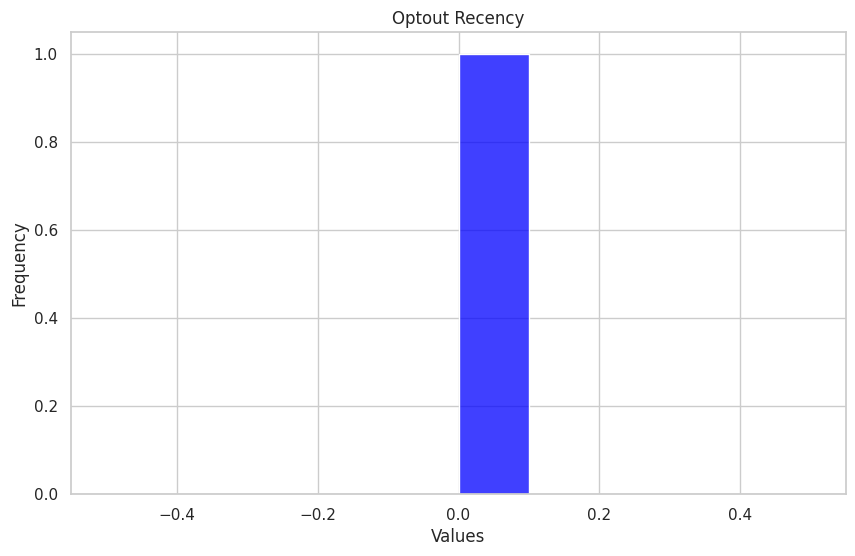

In [63]:
check_enrollment=enrollment[enrollment['optout_recency'] >= 0]


sns.set(style="whitegrid")

# Create a histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(check_enrollment['optout_recency'], bins=10, kde=False, color='blue')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Optout Recency')

# Show the plot
plt.show()

/var/tmp/ipykernel_6008/2429460206.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  enrollment['optout_recency'].fillna(-10, inplace=True)


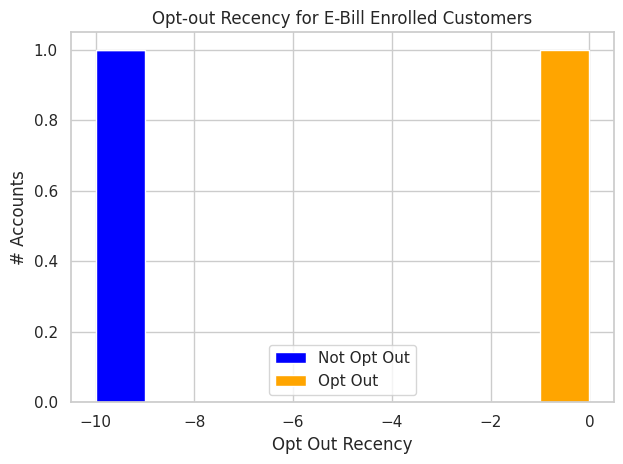

In [64]:
enrollment['optout_recency'].fillna(-10, inplace=True)
group1 = enrollment[enrollment['optout_recency'] < 0]['optout_recency']
group2 = enrollment[enrollment['optout_recency'] >= 0]['optout_recency']

# Plot histogram with different colors for each group
plt.hist([group1, group2], bins=10, stacked=True, color=['blue', 'orange'], label=['Not Opt Out', 'Opt Out'])
plt.xlabel('Opt Out Recency')
plt.ylabel('# Accounts')
plt.title('Opt-out Recency for E-Bill Enrolled Customers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


   optout_recency_tier  record count  record pct
0          a.no optout             1         0.5
1  b1.optout 1-30 days             1         0.5


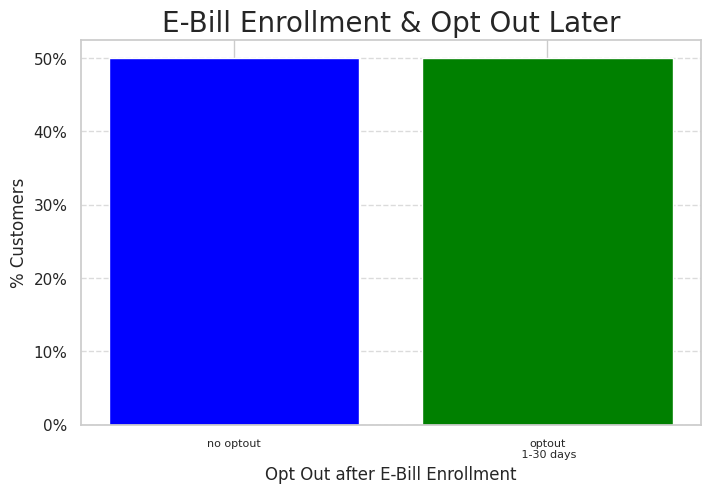

In [65]:
def assign_tier(optout_recency):
    if optout_recency < 0:
        return 'a.no optout'
    elif optout_recency < 30:
        return 'b1.optout 1-30 days'
    elif optout_recency < 60: 
        return 'b2.optout 31-60 days'
    elif optout_recency < 90: 
        return 'b3.optout 61-90 days'
    elif optout_recency < 180: 
        return 'b4.optout 91-180 days'
    else: 
        return 'b5.optout 180+ days'
    
enrollment['optout_recency_tier']=enrollment['optout_recency'].apply(assign_tier)
sum_tier=enrollment.groupby('optout_recency_tier').size().reset_index()
sum_tier.columns=['optout_recency_tier', 'record count']

sum_tier['record pct']=sum_tier['record count']/len(enrollment)
print(sum_tier)

# categories=['no optout', 'optout 1-30 days', 'optout 31-60 days', 'optout 61-90 days', 'optout 91-180 days',  'optout 180+ days']
categories=['no optout', 'optout 1-30 days']
wrapped_labels = [label.replace("optout", "optout\n") for label in categories]
colors=['blue']+['green']*(len(categories)-1)

# Create the bar chart
plt.figure(figsize=(8, 5))
#plt.bar(sum_tier['optout_recency_tier'], sum_tier['record pct'], color='skyblue')
plt.bar(wrapped_labels, sum_tier['record pct'], color=colors)
plt.xlabel('Opt Out after E-Bill Enrollment')
plt.ylabel('% Customers')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=0, fontsize=8)
plt.title('E-Bill Enrollment & Opt Out Later', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [66]:
enrollment.to_csv(str(path_name)+str('/enrollment.csv'), index=False)

## 2 - Extract data from Snowflake
* We need to pull data by segment due to limited computing power in both Snowflake and GCP. 
* The segmented data will be merged later. 

#### 2.1.1 - ContractAccount Level count variable

In [67]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_30D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_30D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_60D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_60D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_90D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_90D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
full outer join 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_180D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_180D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) d
on a.ev_obj_nbr=d.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_360D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_360D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) e
on a.ev_obj_nbr=e.ev_obj_nbr
where e.ev_obj_nbr > 0

"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810284 entries, 0 to 6810283
Data columns (total 31 columns):
 #   Column            Dtype  
---  ------            -----  
 0   cact              object 
 1   inpl_ca_ct_30d    float64
 2   invce_ca_ct_30d   float64
 3   lock_ca_ct_30d    float64
 4   pcomm_ca_ct_30d   float64
 5   pred_ca_ct_30d    float64
 6   pymt_ca_ct_30d    float64
 7   inpl_ca_ct_60d    float64
 8   invce_ca_ct_60d   float64
 9   lock_ca_ct_60d    float64
 10  pcomm_ca_ct_60d   float64
 11  pred_ca_ct_60d    float64
 12  pymt_ca_ct_60d    float64
 13  inpl_ca_ct_90d    float64
 14  invce_ca_ct_90d   float64
 15  lock_ca_ct_90d    float64
 16  pcomm_ca_ct_90d   float64
 17  pred_ca_ct_90d    float64
 18  pymt_ca_ct_90d    float64
 19  inpl_ca_ct_180d   float64
 20  invce_ca_ct_180d  float64
 21  lock_ca_ct_180d   float64
 22  pcomm_ca_ct_180d  float64
 23  pred_ca_ct_180d   float64
 24  pymt_ca_ct_180d   float64
 25  inpl_ca_ct_360d   floa

In [68]:
df.to_csv(str(path_name)+str('/CACT_event_ct.csv'), index=False)

In [69]:
df.head()

,cact,inpl_ca_ct_30d,invce_ca_ct_30d,lock_ca_ct_30d,pcomm_ca_ct_30d,pred_ca_ct_30d,pymt_ca_ct_30d,inpl_ca_ct_60d,invce_ca_ct_60d,lock_ca_ct_60d,pcomm_ca_ct_60d,pred_ca_ct_60d,pymt_ca_ct_60d,inpl_ca_ct_90d,invce_ca_ct_90d,lock_ca_ct_90d,pcomm_ca_ct_90d,pred_ca_ct_90d,pymt_ca_ct_90d,inpl_ca_ct_180d,invce_ca_ct_180d,lock_ca_ct_180d,pcomm_ca_ct_180d,pred_ca_ct_180d,pymt_ca_ct_180d,inpl_ca_ct_360d,invce_ca_ct_360d,lock_ca_ct_360d,pcomm_ca_ct_360d,pred_ca_ct_360d,pymt_ca_ct_360d
0,700985017462,NaN,1.0,2.0,NaN,NaN,1.0,NaN,2.0,4.0,NaN,NaN,2.0,NaN,3.0,6.0,NaN,NaN,2.0,NaN,3.0,6.0,NaN,NaN,2.0,NaN,3.0,6.0,NaN,NaN,2.0
1,700985435774,NaN,1.0,1.0,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,3.0,4.0,NaN,NaN,2.0,NaN,3.0,4.0,NaN,NaN,2.0,NaN,3.0,4.0,NaN,NaN,2.0
2,700411237709,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,2.0,NaN,1.0,1.0,NaN,2.0,2.0,NaN,2.0,2.0,NaN,5.0,5.0,NaN,2.0,3.0,NaN,11.0,11.0,NaN,2.0,5.0
3,700579697912,NaN,1.0,1.0,NaN,NaN,1.0,NaN,2.0,2.0,NaN,NaN,2.0,NaN,3.0,3.0,NaN,NaN,3.0,NaN,6.0,7.0,NaN,NaN,5.0,NaN,12.0,14.0,NaN,NaN,10.0
4,700577911694,NaN,1.0,1.0,NaN,NaN,1.0,NaN,2.0,2.0,NaN,NaN,2.0,NaN,3.0,3.0,NaN,NaN,3.0,NaN,6.0,6.0,NaN,NaN,6.0,NaN,12.0,15.0,NaN,NaN,12.0


#### 2.1.2 - ContractAccount Level recency

In [70]:
# recency in past 365 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select ev_obj_nbr as cact, * from 
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_recency') as event_type, 
        min(datediff(day, to_date(EV_TYPE_VAL_DT_1), current_date)) as ev_type_recency
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  AND to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -365, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_recency')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_recency')
)
PIVOT (max(ev_type_recency) for event_type in (
    select distinct concat(ev_type, '_CA_recency')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
    and EV_TYPE_VAL_DT_1 between DATEADD(day, -365, current_date) and DATEADD(day, -1, current_date))
)
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820319 entries, 0 to 6820318
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   cact              object 
 1   inpl_ca_recency   float64
 2   invce_ca_recency  float64
 3   lock_ca_recency   float64
 4   pcomm_ca_recency  float64
 5   pred_ca_recency   float64
 6   pymt_ca_recency   float64
dtypes: float64(6), object(1)
memory usage: 364.2+ MB


In [71]:
df.to_csv(str(path_name)+str('/CACT_event_recency.csv'), index=False)

#### 2.1.3 - event amount

In [72]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_30D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_30D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_60D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_60D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_90D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_90D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
full outer join 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_180D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_180D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) d
on a.ev_obj_nbr=d.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_360D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_360D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) e
on a.ev_obj_nbr=e.ev_obj_nbr
where e.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810284 entries, 0 to 6810283
Data columns (total 31 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   cact              object
 1   inpl_ca_am_30d    object
 2   invce_ca_am_30d   object
 3   lock_ca_am_30d    object
 4   pcomm_ca_am_30d   object
 5   pred_ca_am_30d    object
 6   pymt_ca_am_30d    object
 7   inpl_ca_am_60d    object
 8   invce_ca_am_60d   object
 9   lock_ca_am_60d    object
 10  pcomm_ca_am_60d   object
 11  pred_ca_am_60d    object
 12  pymt_ca_am_60d    object
 13  inpl_ca_am_90d    object
 14  invce_ca_am_90d   object
 15  lock_ca_am_90d    object
 16  pcomm_ca_am_90d   object
 17  pred_ca_am_90d    object
 18  pymt_ca_am_90d    object
 19  inpl_ca_am_180d   object
 20  invce_ca_am_180d  object
 21  lock_ca_am_180d   object
 22  pcomm_ca_am_180d  object
 23  pred_ca_am_180d   object
 24  pymt_ca_am_180d   object
 25  inpl_ca_am_360d   object
 26  invce_ca_am_360d  o

In [73]:
df.to_csv(str(path_name)+str('/CACT_event_amt.csv'), index=False)

#### 2.2.1 - subtype count
* Snowflake-GCP pipeline has a bottleneck with regard to how much data an be transported. 
* Therefore, we divided the data extraction into two steps. 

In [74]:
#1-90 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_30') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_30')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_30')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_30')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_60') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_60')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_60')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_60')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_90') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_90')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_90')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_90')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
where c.ev_obj_nbr > 0

"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5766590 entries, 0 to 5766589
Data columns (total 67 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   cact                            object 
 1   cact-dunn_ca_sub_ct_30          float64
 2   cact-intr_ca_sub_ct_30          float64
 3   cact-inv_ca_sub_ct_30           float64
 4   cact-ipymt_ca_sub_ct_30         float64
 5   cact-opymt_ca_sub_ct_30         float64
 6   cact-post_ca_sub_ct_30          float64
 7   cleared_ca_sub_ct_30            float64
 8   closed_ca_sub_ct_30             float64
 9   collprop_ca_sub_ct_30           float64
 10  create_ca_sub_ct_30             float64
 11  deactive_ca_sub_ct_30           float64
 12  fica-dunn_ca_sub_ct_30          float64
 13  fica-intr_ca_sub_ct_30          float64
 14  fica-post_ca_sub_ct_30          float64
 15  fica-pymt_ca_sub_ct_30          float64
 16  ip_amp_paymentdue_ca_sub_ct_30  float64
 17  mimo

In [75]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_ct_1.csv'), index=False)

In [76]:
# 180-360 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_180') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_180')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_180')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_180')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) d
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_360') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_360')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_360')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_360')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) e
on d.ev_obj_nbr=e.ev_obj_nbr
where e.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810284 entries, 0 to 6810283
Data columns (total 45 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cact                             object 
 1   cact-dunn_ca_sub_ct_180          float64
 2   cact-intr_ca_sub_ct_180          float64
 3   cact-inv_ca_sub_ct_180           float64
 4   cact-ipymt_ca_sub_ct_180         float64
 5   cact-opymt_ca_sub_ct_180         float64
 6   cact-post_ca_sub_ct_180          float64
 7   cleared_ca_sub_ct_180            float64
 8   closed_ca_sub_ct_180             float64
 9   collprop_ca_sub_ct_180           float64
 10  create_ca_sub_ct_180             float64
 11  deactive_ca_sub_ct_180           float64
 12  fica-dunn_ca_sub_ct_180          float64
 13  fica-intr_ca_sub_ct_180          float64
 14  fica-post_ca_sub_ct_180          float64
 15  fica-pymt_ca_sub_ct_180          float64
 16  ip_amp_paymentdue_ca_sub_ct_180

In [77]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_ct_2.csv'), index=False)

#### 2.2.2 - subtype recency

In [78]:
# recency in past 365 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select ev_obj_nbr as cact, * from 
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_recency') as event_subtype, 
        min(datediff(day, to_date(EV_TYPE_VAL_DT_1), '2025-08-11')) as ev_sub_recency
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  AND to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -365, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_recency')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_recency')
)
PIVOT (max(ev_sub_recency) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_recency')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
    and EV_TYPE_VAL_DT_1 between DATEADD(day, -365, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)
where ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6754420 entries, 0 to 6754419
Data columns (total 23 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   cact                              object 
 1   cact-dunn_ca_sub_recency          float64
 2   cact-intr_ca_sub_recency          float64
 3   cact-inv_ca_sub_recency           float64
 4   cact-ipymt_ca_sub_recency         float64
 5   cact-opymt_ca_sub_recency         float64
 6   cact-post_ca_sub_recency          float64
 7   cleared_ca_sub_recency            float64
 8   closed_ca_sub_recency             float64
 9   collprop_ca_sub_recency           float64
 10  create_ca_sub_recency             float64
 11  deactive_ca_sub_recency           float64
 12  fica-dunn_ca_sub_recency          float64
 13  fica-intr_ca_sub_recency          float64
 14  fica-post_ca_sub_recency          float64
 15  fica-pymt_ca_sub_recency          float64
 16  ip_amp_paymen

In [79]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_recency.csv'), index=False)

#### 2.2.3 - subtype amount

In [80]:
#1-90 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_30') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_30')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_30')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_30')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_60') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_60')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_60')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_60')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_90') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_90')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_90')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_90')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
where c.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5766590 entries, 0 to 5766589
Data columns (total 67 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   cact                            object
 1   cact-dunn_ca_sub_am_30          object
 2   cact-intr_ca_sub_am_30          object
 3   cact-inv_ca_sub_am_30           object
 4   cact-ipymt_ca_sub_am_30         object
 5   cact-opymt_ca_sub_am_30         object
 6   cact-post_ca_sub_am_30          object
 7   cleared_ca_sub_am_30            object
 8   closed_ca_sub_am_30             object
 9   collprop_ca_sub_am_30           object
 10  create_ca_sub_am_30             object
 11  deactive_ca_sub_am_30           object
 12  fica-dunn_ca_sub_am_30          object
 13  fica-intr_ca_sub_am_30          object
 14  fica-post_ca_sub_am_30          object
 15  fica-pymt_ca_sub_am_30          object
 16  ip_amp_paymentdue_ca_sub_am_30  object
 17  mimo_day_before_ca_sub_

In [81]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_am_1.csv'), index=False)

In [82]:
#180-365 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_180') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_180')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_180')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_180')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) d
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_360') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_360')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_360')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_360')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) e
on d.ev_obj_nbr=e.ev_obj_nbr
and e.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810284 entries, 0 to 6810283
Data columns (total 45 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   cact                             object
 1   cact-dunn_ca_sub_am_180          object
 2   cact-intr_ca_sub_am_180          object
 3   cact-inv_ca_sub_am_180           object
 4   cact-ipymt_ca_sub_am_180         object
 5   cact-opymt_ca_sub_am_180         object
 6   cact-post_ca_sub_am_180          object
 7   cleared_ca_sub_am_180            object
 8   closed_ca_sub_am_180             object
 9   collprop_ca_sub_am_180           object
 10  create_ca_sub_am_180             object
 11  deactive_ca_sub_am_180           object
 12  fica-dunn_ca_sub_am_180          object
 13  fica-intr_ca_sub_am_180          object
 14  fica-post_ca_sub_am_180          object
 15  fica-pymt_ca_sub_am_180          object
 16  ip_amp_paymentdue_ca_sub_am_180  object
 17  mimo

In [83]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_am_2.csv'), index=False)

#### 2.3 - event type and subtype combined

#### 2.3.1 - count

In [84]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5896710 entries, 0 to 5896709
Data columns (total 73 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   cact                               object 
 1   inplZcleared_ca_ct_30d             float64
 2   inplZclosed_ca_ct_30d              float64
 3   inplZcreate_ca_ct_30d              float64
 4   inplZdeactive_ca_ct_30d            float64
 5   inplZoverdue_ca_ct_30d             float64
 6   invceZcreate_ca_ct_30d             float64
 7   invceZrever_ca_ct_30d              float64
 8   lockZcact-dunn_ca_ct_30d           float64
 9   lockZcact-intr_ca_ct_30d           float64
 10  lockZcact-inv_ca_ct_30d            float64
 11  lockZcact-ipymt_ca_ct_30d          float64
 12  lockZcact-opymt_ca_ct_30d          float64
 13  lockZcact-post_ca_ct_30d           float64
 14  lockZfica-dunn_ca_ct_30d           float64
 15  lockZfica-intr_ca_ct_30d           float64


In [85]:
df.to_csv(str(path_name)+str('/CACT_event_com_ct_1.csv'), index=False)

In [86]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select b.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
where b.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810284 entries, 0 to 6810283
Data columns (total 49 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   cact                                object 
 1   inplZcleared_ca_ct_180d             float64
 2   inplZclosed_ca_ct_180d              float64
 3   inplZcreate_ca_ct_180d              float64
 4   inplZdeactive_ca_ct_180d            float64
 5   inplZoverdue_ca_ct_180d             float64
 6   invceZcreate_ca_ct_180d             float64
 7   invceZrever_ca_ct_180d              float64
 8   lockZcact-dunn_ca_ct_180d           float64
 9   lockZcact-intr_ca_ct_180d           float64
 10  lockZcact-inv_ca_ct_180d            float64
 11  lockZcact-ipymt_ca_ct_180d          float64
 12  lockZcact-opymt_ca_ct_180d          float64
 13  lockZcact-post_ca_ct_180d           float64
 14  lockZfica-dunn_ca_ct_180d           float64
 15  lockZfica-intr_ca_ct_180d 

In [87]:
df.shape

(6810284, 49)

In [88]:
df.to_csv(str(path_name)+str('/CACT_event_com_ct_2.csv'), index=False)

#### 2.3.2 - recency

In [89]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select ev_obj_nbr as cact, * from 
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_recency') as event_type, 
        min(datediff(day, to_date(EV_TYPE_VAL_DT_1), current_date)) as ev_type_recency
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  AND to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -365, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_recency')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_recency')
)
PIVOT (max(ev_type_recency) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_recency')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
    and EV_TYPE_VAL_DT_1 between DATEADD(day, -365, current_date) and DATEADD(day, -1, current_date))
)
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820319 entries, 0 to 6820318
Data columns (total 25 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   cact                                object 
 1   inplZcleared_ca_recency             float64
 2   inplZclosed_ca_recency              float64
 3   inplZcreate_ca_recency              float64
 4   inplZdeactive_ca_recency            float64
 5   inplZoverdue_ca_recency             float64
 6   invceZcreate_ca_recency             float64
 7   invceZrever_ca_recency              float64
 8   lockZcact-dunn_ca_recency           float64
 9   lockZcact-intr_ca_recency           float64
 10  lockZcact-inv_ca_recency            float64
 11  lockZcact-ipymt_ca_recency          float64
 12  lockZcact-opymt_ca_recency          float64
 13  lockZcact-post_ca_recency           float64
 14  lockZfica-dunn_ca_recency           float64
 15  lockZfica-intr_ca_recency 

In [90]:
df.to_csv(str(path_name)+str('/CACT_event_com_recency.csv'), index=False)

#### 2.3.3 - amount

In [91]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5896710 entries, 0 to 5896709
Data columns (total 73 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   cact                               object
 1   inplZcleared_ca_am_30d             object
 2   inplZclosed_ca_am_30d              object
 3   inplZcreate_ca_am_30d              object
 4   inplZdeactive_ca_am_30d            object
 5   inplZoverdue_ca_am_30d             object
 6   invceZcreate_ca_am_30d             object
 7   invceZrever_ca_am_30d              object
 8   lockZcact-dunn_ca_am_30d           object
 9   lockZcact-intr_ca_am_30d           object
 10  lockZcact-inv_ca_am_30d            object
 11  lockZcact-ipymt_ca_am_30d          object
 12  lockZcact-opymt_ca_am_30d          object
 13  lockZcact-post_ca_am_30d           object
 14  lockZfica-dunn_ca_am_30d           object
 15  lockZfica-intr_ca_am_30d           object
 16  lockZfica-pos

In [92]:
df.to_csv(str(path_name)+str('/CACT_event_com_am_1.csv'), index=False)

In [93]:
# recency in past 365 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select b.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
where b.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810284 entries, 0 to 6810283
Data columns (total 49 columns):
 #   Column                              Dtype 
---  ------                              ----- 
 0   cact                                object
 1   inplZcleared_ca_am_180d             object
 2   inplZclosed_ca_am_180d              object
 3   inplZcreate_ca_am_180d              object
 4   inplZdeactive_ca_am_180d            object
 5   inplZoverdue_ca_am_180d             object
 6   invceZcreate_ca_am_180d             object
 7   invceZrever_ca_am_180d              object
 8   lockZcact-dunn_ca_am_180d           object
 9   lockZcact-intr_ca_am_180d           object
 10  lockZcact-inv_ca_am_180d            object
 11  lockZcact-ipymt_ca_am_180d          object
 12  lockZcact-opymt_ca_am_180d          object
 13  lockZcact-post_ca_am_180d           object
 14  lockZfica-dunn_ca_am_180d           object
 15  lockZfica-intr_ca_am_180d           object


In [94]:
df.to_csv(str(path_name)+str('/CACT_event_com_am_2.csv'), index=False)

#### 2.4 - Customers with hard copy

In [95]:
# recency in past 365 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select distinct CONTRACTACCOUNT
from PROD_CS.CORE_V.CS_D_ENERGY_CONSUMER_CUSTOMER_CONTRACT_VW_C
where accountclass='RESI' 
  and moveindate <= current_date
  and moveoutdate='9999-12-31'
  and trim(dcfororgcust) in ('HCB', '')
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657210 entries, 0 to 1657209
Data columns (total 1 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   contractaccount  1657210 non-null  object
dtypes: object(1)
memory usage: 12.6+ MB


In [96]:
df.to_csv(str(path_name)+str('/cust_with_letterbill_sf.csv'), index=False)

## Part 3 - combine data
#### 3.0 - all active customers without Ebill enrollment

In [16]:
all_resi_model=pd.read_csv(str(path_name)+str('/all_resi_model.csv'))
all_resi_model.drop_duplicates(subset='cact', keep='first', inplace=True)
#all_resi_model=all_resi_model[all_resi_model['0UCACC_CLAS'].str.strip()=='RESI']
all_resi_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4586112 entries, 0 to 4687990
Data columns (total 15 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cact           int64 
 1   bp             int64 
 2   rate_plan      object
 3   rate_plan_cat  object
 4   unit_num       int64 
 5   landline       int64 
 6   mobilephone    int64 
 7   having_phone   int64 
 8   cust_type      object
 9   critical_care  object
 10  cactnum        int64 
 11  movein_date    object
 12  moveoutdate    object
 13  bill_type      object
 14  have_email     int64 
dtypes: int64(8), object(7)
memory usage: 559.8+ MB


In [17]:
customers_with_letterbill=pd.read_csv(str(path_name)+str('/cust_with_letterbill_sf.csv'))
customers_with_letterbill.rename(columns={'contractaccount': 'cact'}, inplace=True)
customers_with_letterbill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657210 entries, 0 to 1657209
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   cact    1657210 non-null  int64
dtypes: int64(1)
memory usage: 12.6 MB


In [18]:
merge_two=pd.merge(all_resi_model.assign(sap=1), customers_with_letterbill.assign(sf=1), 
                   on='cact', how='outer')
merge_two[['sap', 'sf']]=merge_two[['sap', 'sf']].fillna(0)
merge_two.shape

(4586915, 17)

In [19]:
merge_two[['sap', 'sf']].isnull().sum()

sap    0
sf     0
dtype: int64

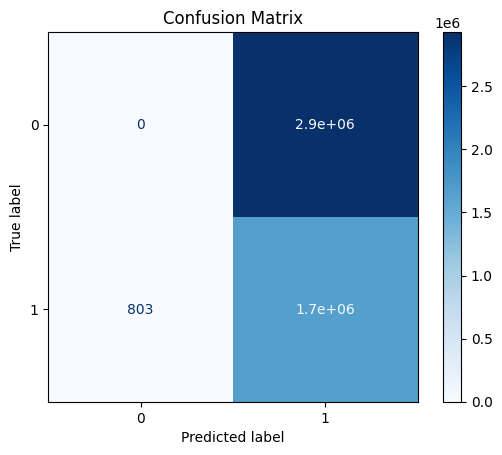

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(merge_two['sf'], merge_two['sap'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [21]:
# enrolled customers
unenrolled_resi=merge_two[(merge_two['sf']==1) & (merge_two['sap']==1)]
unenrolled_resi.drop(['sap', 'sf'], axis=1, inplace=True)
unenrolled_resi.info()                                              

/var/tmp/ipykernel_7558/2152734140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unenrolled_resi.drop(['sap', 'sf'], axis=1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1656407 entries, 1 to 4586837
Data columns (total 15 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   cact           1656407 non-null  int64  
 1   bp             1656407 non-null  float64
 2   rate_plan      1656407 non-null  object 
 3   rate_plan_cat  1656407 non-null  object 
 4   unit_num       1656407 non-null  float64
 5   landline       1656407 non-null  float64
 6   mobilephone    1656407 non-null  float64
 7   having_phone   1656407 non-null  float64
 8   cust_type      1656407 non-null  object 
 9   critical_care  651124 non-null   object 
 10  cactnum        1656407 non-null  float64
 11  movein_date    1656407 non-null  object 
 12  moveoutdate    1656407 non-null  object 
 13  bill_type      1385232 non-null  object 
 14  have_email     1656407 non-null  float64
dtypes: float64(7), int64(1), object(7)
memory usage: 202.2+ MB


* Use the data from Snowflake as the basefile for scoring. 

#### 3.1 - find customers with emails

In [22]:
# match with email address
email_myacct=pd.read_csv(str(path_name)+str('/email_myacct.csv'))
email_myacct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6407129 entries, 0 to 6407128
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   cact              int64 
 1   bp                int64 
 2   email_valid_from  object
 3   email_valid_to    object
 4   email             object
dtypes: int64(2), object(3)
memory usage: 244.4+ MB


In [23]:
email_contact=pd.read_csv(str(path_name)+str('/email_contact.csv'))
email_contact.info()

/var/tmp/ipykernel_7558/283552811.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  email_contact=pd.read_csv(str(path_name)+str('/email_contact.csv'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10622574 entries, 0 to 10622573
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   bp                  object
 1   ZCOMM_VALIDFRM      object
 2   ZCOMM_VALIDTO       object
 3   bp_email            object
 4   email_contact_from  object
 5   email_contact_to    object
dtypes: object(6)
memory usage: 486.3+ MB


In [24]:
# merge by email
email_myacct.drop_duplicates(subset=['bp', 'cact', 'email'], keep='first', inplace=True)
email_myacct['email']=email_myacct['email'].str.strip()  # remove extra space for later merging
print(email_myacct.shape)

email_contact.drop_duplicates(subset=['bp', 'bp_email'], keep='first', inplace=True)
email_contact.rename(columns={'bp_email': 'email'}, inplace=True)
email_contact['email']=email_contact['email'].str.strip() # remove extra space for later merging
print(email_contact.shape)

(6398962, 5)
(9659464, 6)


In [25]:
email_contact.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9659464 entries, 0 to 10622573
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   bp                  object
 1   ZCOMM_VALIDFRM      object
 2   ZCOMM_VALIDTO       object
 3   email               object
 4   email_contact_from  object
 5   email_contact_to    object
dtypes: object(6)
memory usage: 515.9+ MB


In [26]:
email_myacct_contact=pd.merge(email_myacct[['bp', 'cact', 'email']], email_contact[['bp', 'email']], on=['bp', 'email'], how='outer')
print(email_myacct_contact.shape)
email_myacct_contact.info()

email_myacct_contact.drop_duplicates(subset=['bp', 'cact', 'email'], keep='first', inplace=True)
email_count_cact=email_myacct_contact.groupby(['bp', 'cact'])['email'].nunique().reset_index().rename(columns={'email': 'email_cnt_cact'})
bp_cact_count=email_myacct_contact.groupby('bp')['cact'].nunique().reset_index().rename(columns={'cact': 'cact_cnt'})
print(email_count_cact.shape)

email_count_bp=email_myacct_contact.groupby('bp')['email'].nunique().reset_index().rename(columns={'email': 'email_cnt_bp'})
print(email_count_bp.shape)

(14979981, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14979981 entries, 0 to 14979980
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   bp      object 
 1   cact    float64
 2   email   object 
dtypes: float64(1), object(2)
memory usage: 342.9+ MB
(5734186, 3)
(9014384, 2)


In [27]:
bp_email=pd.merge(bp_cact_count, email_count_bp, on='bp', how='outer') 
email_info=pd.merge(bp_email, email_count_cact, on='bp', how='outer') 
email_info.info() 
email_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10259898 entries, 0 to 10259897
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bp              object 
 1   cact_cnt        int64  
 2   email_cnt_bp    int64  
 3   cact            float64
 4   email_cnt_cact  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 391.4+ MB


,bp,cact_cnt,email_cnt_bp,cact,email_cnt_cact
0,1000000019,1,2,4.000000e+11,1.0
1,1000000026,0,1,NaN,NaN
2,1000000027,0,6,NaN,NaN
3,1000000028,3,6,7.008630e+11,2.0
4,1000000028,3,6,7.009357e+11,2.0


In [28]:
cact_with_email=email_info[email_info['cact'].isnull()==False]
cact_with_email['with_email']=np.where((cact_with_email['email_cnt_bp'] > 0) | (cact_with_email['email_cnt_cact'] > 0), 1, 0)
cact_with_email=cact_with_email[cact_with_email['with_email'] > 0]
cact_with_email.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5734186 entries, 0 to 7736564
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bp              object 
 1   cact_cnt        int64  
 2   email_cnt_bp    int64  
 3   cact            float64
 4   email_cnt_cact  float64
 5   with_email      int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 306.2+ MB


/var/tmp/ipykernel_7558/2154396345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cact_with_email['with_email']=np.where((cact_with_email['email_cnt_bp'] > 0) | (cact_with_email['email_cnt_cact'] > 0), 1, 0)


In [29]:
cact_with_email['cact'].nunique()

5734186

In [30]:
unenrolled_resi.shape

(1656407, 15)

In [31]:
# flag cact with email addresses from MyAccount
cact_with_email.drop('bp', axis=1, inplace=True),
cact_for_model=pd.merge(unenrolled_resi, cact_with_email, on='cact', how='inner')
cact_for_model.info()
cact_for_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582748 entries, 0 to 582747
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   cact            582748 non-null  int64  
 1   bp              582748 non-null  float64
 2   rate_plan       582748 non-null  object 
 3   rate_plan_cat   582748 non-null  object 
 4   unit_num        582748 non-null  float64
 5   landline        582748 non-null  float64
 6   mobilephone     582748 non-null  float64
 7   having_phone    582748 non-null  float64
 8   cust_type       582748 non-null  object 
 9   critical_care   450904 non-null  object 
 10  cactnum         582748 non-null  float64
 11  movein_date     582748 non-null  object 
 12  moveoutdate     582748 non-null  object 
 13  bill_type       486214 non-null  object 
 14  have_email      582748 non-null  float64
 15  cact_cnt        582748 non-null  int64  
 16  email_cnt_bp    582748 non-null  int64  
 17  email_cnt_

,cact,bp,rate_plan,rate_plan_cat,unit_num,landline,mobilephone,having_phone,cust_type,critical_care,cactnum,movein_date,moveoutdate,bill_type,have_email,cact_cnt,email_cnt_bp,email_cnt_cact,with_email
0,700000041470,1.003887e+09,DM,DM,1.0,1.0,1.0,1.0,Domestic,No,8.011910e+09,2021-10-05,9999-12-31,HCB,1.0,1,3,1.0,1
1,700000053493,1.004600e+09,TOUD-4-9PM-CARE,TD49,1.0,1.0,1.0,1.0,Domestic,NaN,8.003596e+09,2021-03-24,9999-12-31,HCB,1.0,1,2,1.0,1
2,700000540719,1.005000e+09,DOMESTIC,D,1.0,1.0,1.0,1.0,Domestic,No,8.003553e+09,2021-03-04,9999-12-31,HCB,1.0,3,2,1.0,1
3,700000542032,1.001814e+09,TOU-D-PRIME,TDPRIME,1.0,1.0,1.0,1.0,Domestic,No,8.002483e+09,2021-03-05,9999-12-31,HCB,1.0,1,2,1.0,1
4,700000542739,1.001376e+09,TOUD-4-9PM,TD49,1.0,1.0,1.0,1.0,Domestic,NaN,8.004488e+09,2021-03-26,9999-12-31,HCB,1.0,1,1,1.0,1


In [32]:
past_enroll=pd.read_csv(str(path_name)+str('/past_enroll.csv'))
past_optout=pd.read_csv(str(path_name)+str('/past_optout.csv'))

In [33]:
past_enroll['cact']=pd.to_numeric(past_enroll['cact'], errors='coerce')
past_optout['cact']=pd.to_numeric(past_optout['cact'], errors='coerce')
past_optout.info()
past_optout.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894420 entries, 0 to 894419
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   894420 non-null  int64 
 1   latest_optout_date     894420 non-null  object
 2   last_optout_recency    894420 non-null  int64 
 3   optout_cnt_total       894420 non-null  int64 
 4   optout_cnt_lastyear    894420 non-null  int64 
 5   optout_cnt_last2years  894420 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 40.9+ MB


,cact,latest_optout_date,last_optout_recency,optout_cnt_total,optout_cnt_lastyear,optout_cnt_last2years
0,700291241837,2022-10-03,1071,1,0,0
1,700871320530,2025-07-10,60,1,1,1
2,700005867635,2025-01-31,220,1,1,1
3,700928219821,2025-08-03,36,2,2,2
4,700171756227,2023-06-24,807,1,0,0


In [34]:
print(past_optout['latest_optout_date'].min())
print(past_optout['latest_optout_date'].max())

2021-04-06
2025-09-07


In [35]:
past_optout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894420 entries, 0 to 894419
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   894420 non-null  int64 
 1   latest_optout_date     894420 non-null  object
 2   last_optout_recency    894420 non-null  int64 
 3   optout_cnt_total       894420 non-null  int64 
 4   optout_cnt_lastyear    894420 non-null  int64 
 5   optout_cnt_last2years  894420 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 40.9+ MB


In [36]:
# merge three files
cact_for_model['eligible']=1
dfs=[cact_for_model, past_enroll, past_optout]

for_modeling = reduce(lambda left, right: pd.merge(left, right, on='cact', how='outer'), dfs)
for_modeling=for_modeling[for_modeling['eligible']==1]
for_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582748 entries, 90 to 1219829
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cact                   582748 non-null  int64  
 1   bp                     582748 non-null  float64
 2   rate_plan              582748 non-null  object 
 3   rate_plan_cat          582748 non-null  object 
 4   unit_num               582748 non-null  float64
 5   landline               582748 non-null  float64
 6   mobilephone            582748 non-null  float64
 7   having_phone           582748 non-null  float64
 8   cust_type              582748 non-null  object 
 9   critical_care          450904 non-null  object 
 10  cactnum                582748 non-null  float64
 11  movein_date            582748 non-null  object 
 12  moveoutdate            582748 non-null  object 
 13  bill_type              486214 non-null  object 
 14  have_email             582748 non-null 

In [37]:
print(cact_for_model['cact'].count(), cact_for_model['cact'].nunique())
print(past_enroll['cact'].count(), past_enroll['cact'].nunique())
print(past_optout['cact'].count(), past_optout['cact'].nunique())
for_modeling['cact'].nunique()

582748 582748
894420 894420
894420 894420


582748

In [38]:
past_optout.describe()

,cact,last_optout_recency,optout_cnt_total,optout_cnt_lastyear,optout_cnt_last2years
count,8.944200e+05,894420.000000,894420.000000,894420.000000,894420.000000
mean,7.004624e+11,667.941856,1.218248,0.389678,0.628685
std,1.059390e+09,430.585123,0.784710,0.784501,0.920962
min,5.000010e+11,1.000000,1.000000,0.000000,0.000000
25%,7.002372e+11,276.000000,1.000000,0.000000,0.000000
50%,7.004798e+11,732.000000,1.000000,0.000000,0.000000
75%,7.007042e+11,929.000000,1.000000,1.000000,1.000000
max,7.010031e+11,1616.000000,39.000000,37.000000,39.000000


In [39]:
# Use Nicole's definition for customers with active accounts back on 06/25/2025
for_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582748 entries, 90 to 1219829
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cact                   582748 non-null  int64  
 1   bp                     582748 non-null  float64
 2   rate_plan              582748 non-null  object 
 3   rate_plan_cat          582748 non-null  object 
 4   unit_num               582748 non-null  float64
 5   landline               582748 non-null  float64
 6   mobilephone            582748 non-null  float64
 7   having_phone           582748 non-null  float64
 8   cust_type              582748 non-null  object 
 9   critical_care          450904 non-null  object 
 10  cactnum                582748 non-null  float64
 11  movein_date            582748 non-null  object 
 12  moveoutdate            582748 non-null  object 
 13  bill_type              486214 non-null  object 
 14  have_email             582748 non-null 

#### 3.2 - append predictors/attributes

In [40]:
excl_exempt=pd.read_csv(str(path_name)+str('/excl_exempt.csv'))
excl_exempt.rename(columns={'ZBP_PART': 'bp'}, inplace=True)
excl_exempt.drop_duplicates(subset='bp', keep='first', inplace=True)
model_sample2=pd.merge(for_modeling, excl_exempt[['bp']].assign(exempt=1), on='bp', how='left')
model_sample2['exempt'].fillna(0, inplace=True)
print(model_sample2['exempt'].sum())
print(model_sample2['exempt'].mean())
model_sample2.shape

/var/tmp/ipykernel_7558/4024619232.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  excl_exempt=pd.read_csv(str(path_name)+str('/excl_exempt.csv'))


64833.0
0.11125392107737822


/var/tmp/ipykernel_7558/4024619232.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_sample2['exempt'].fillna(0, inplace=True)


(582748, 31)

In [41]:
excl_payment_1yr=pd.read_csv(str(path_name)+str('/excl_payment_1yr.csv'))
excl_payment_1yr.drop_duplicates(subset='cact', inplace=True)
excl_payment_1yr.info()

model_sample2=pd.merge(model_sample2, excl_payment_1yr, on='cact', how='left')
model_sample2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3595647 entries, 0 to 4117120
Data columns (total 4 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   cact                  int64 
 1   pymt_type             object
 2   last_pymt_date        object
 3   last_payment_recency  int64 
dtypes: int64(2), object(2)
memory usage: 137.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582748 entries, 0 to 582747
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cact                   582748 non-null  int64  
 1   bp                     582748 non-null  float64
 2   rate_plan              582748 non-null  object 
 3   rate_plan_cat          582748 non-null  object 
 4   unit_num               582748 non-null  float64
 5   landline               582748 non-null  float64
 6   mobilephone            582748 non-null  float64
 7   having_phone           582748 non-null  floa

In [42]:
df=pd.read_csv(str(path_name)+str('/payment_type.csv'))

model_sample2=pd.merge(model_sample2, df, on='cact', how='left')
model_sample2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582748 entries, 0 to 582747
Columns: 219 entries, cact to recency_WT
dtypes: float64(207), int64(1), object(11)
memory usage: 973.7+ MB


* Due to the large size of each file, we merge it with each file sequentially. 

In [43]:
df=pd.read_csv(str(path_name)+str('/CACT_event_ct.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_recency.csv'))
df.fillna(600, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_amt.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_ct_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_ct_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_recency.csv'))
df.fillna(600, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_am_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_am_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_ct_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_ct_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_am_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_am_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_recency.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

In [44]:
model_sample2['movein_dt']=pd.to_datetime(model_sample2['movein_date'].astype(str), format='mixed')
model_sample2['acct_age']=(pd.to_datetime('2025-09-08', format='%Y-%m-%d') - model_sample2['movein_dt']).dt.days
model_sample2.columns = model_sample2.columns.str.replace('-', '_')

In [45]:
model_sample2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582748 entries, 0 to 582747
Columns: 793 entries, cact to acct_age
dtypes: datetime64[ns](1), float64(779), int64(2), object(11)
memory usage: 3.4+ GB


In [46]:
#model_sample2.to_csv(str(path_name)+str('/validation_')+formatted_date+str('.csv'), index=False)
model_sample2.to_csv('gs://ebill_enrollment_model/implementation_20250821/validation_20250908.csv', index=False)

In [52]:
model_sample2[['past_enroll_recency',
 'enroll_cnt_total',
 'enroll_cnt_lastyear',
 'enroll_cnt_last2years',
 'last_optout_recency',
 'optout_cnt_total',
 'optout_cnt_lastyear',
 'optout_cnt_last2years']].describe()

,past_enroll_recency,enroll_cnt_total,enroll_cnt_lastyear,enroll_cnt_last2years,last_optout_recency,optout_cnt_total,optout_cnt_lastyear,optout_cnt_last2years
count,257335.000000,257335.000000,257335.000000,257335.000000,257335.000000,257335.000000,257335.000000,257335.000000
mean,427.676943,1.397501,0.721814,1.052379,427.676943,1.397501,0.721814,1.052379
std,382.144281,1.138084,1.090064,1.168499,382.144281,1.138084,1.090064,1.168499
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,114.000000,1.000000,0.000000,1.000000,114.000000,1.000000,0.000000,1.000000
50%,314.000000,1.000000,1.000000,1.000000,314.000000,1.000000,1.000000,1.000000
75%,643.000000,1.000000,1.000000,1.000000,643.000000,1.000000,1.000000,1.000000
max,1616.000000,39.000000,36.000000,39.000000,1616.000000,39.000000,36.000000,39.000000


#### append acxiom data

In [47]:
#deploy_file=pd.read_csv('gs://ebill_enrollment_model/implementation_20250821/validation_20250908.csv')

In [48]:
# read in Acxiom data
df=pd.read_csv('gs://ebill_enrollment_model/input_data/acxiom_202406.csv')
df['cact']=pd.to_numeric(df['CONTRACT_ACCOUNT'], errors='coerce')
df.drop_duplicates(subset='cact', keep='first', inplace=True)
df.drop(['BP',
 'CONTRACT_ACCOUNT',
 'Contract Number',
 'Service Account Number',
 'INSTALLATION_NUMBER',
 'DEVICE_LOCATION',
 'Customer Full Name',
 'Customer First Name',
 'Customer Last Name',
 'PREMISE',
 'Premise Street Address Number',
 'Premise Street Address Name',
 'Premise Street Address Unit',
 'Premise City',
 'Premise State',
 'Premise ZIP Code'], axis=1, inplace=True)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace(".", '')
df.columns = df.columns.str.replace(",", '')
df.columns = df.columns.str.replace("-", '')
df.columns = df.columns.str.replace(" ", '')
df.columns = df.columns.str.replace("(", '')
df.columns = df.columns.str.replace(")", '')
df.columns = df.columns.str.replace("%", '')
df.columns = df.columns.str.replace("/", '')
#df.columns = df.columns.str.replace('\', '')
df.columns = df.columns.str.replace("=", '_')     
df.columns = df.columns.str.replace("+", '')
df.columns = df.columns.str.replace("$", '')
df.columns = df.columns.str.replace("?", '')
df.columns = df.columns.str.replace("+", '')
df.info()

df=df[['cact', 'IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip',
       'IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip']]

<class 'pandas.core.frame.DataFrame'>
Index: 4458884 entries, 0 to 4491793
Columns: 212 entries, PX001270_01PersonicxLifestageClusterCode170SeeFormatLIFECLS to cact
dtypes: float64(155), int64(2), object(55)
memory usage: 7.1+ GB


In [49]:
deploy_file=pd.merge(model_sample2, df, on='cact', how='left')
deploy_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582748 entries, 0 to 582747
Columns: 795 entries, cact to IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip
dtypes: datetime64[ns](1), float64(779), int64(2), object(13)
memory usage: 3.5+ GB


In [50]:
deploy_file.to_csv(str(path_name)+str('/validation_file_20250908')+str('.csv'), index=False)

In [13]:
del deploy_file

## Part 4 - Scoring

In [6]:
mod=pd.read_csv('gs://ebill_enrollment_model/input_20250811/modeling_enhance_20250625.csv')
val=pd.read_csv(str(path_name)+str('/validation_file_20250908')+str('.csv'))
print(mod.shape)
print(val.shape)

/var/tmp/ipykernel_7632/573314988.py:1: DtypeWarning: Columns (22,26,31,37,38,802,803,804,818,820,821,822,856,872,874,875,876,878,879,880,882,883,884,886,888,890,892,894,895,897,902,903,905,908,910,912,917,918,919,922,924,925,926,978,980,981,982,984,986,988,993,995,997,999,1001,1003,1005,1008,1009,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  mod=pd.read_csv('gs://ebill_enrollment_model/input_20250811/modeling_enhance_20250625.csv')
/var/tmp/ipykernel_7632/573314988.py:2: DtypeWarning: Columns (31,32,793,794) have mixed types. Specify dtype option on import or set low_memory=False.
  val=pd.read_csv(str(path_name)+str('/validation_file_20250908')+str('.csv'))


(529527, 1014)
(582748, 795)


In [7]:
failure_samp=pd.concat([mod.assign(seg='mod'), val.assign(seg='val')])

In [8]:
failure_samp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1112275 entries, 0 to 582747
Columns: 1023 entries, cact to recency_WT
dtypes: float64(952), object(71)
memory usage: 8.5+ GB


In [9]:
del mod, val

In [10]:
def trans_df(df):
    df['create_ca_sub_ct_360'].fillna(0, inplace=True)
    df['invceZcreate_ca_ct_360d'].fillna(0, inplace=True)
    df['pymtZpymt_ca_ct_360d'].fillna(-10, inplace=True)
    df['lockZfica_intr_ca_ct_360d'].fillna(-2, inplace=True)
    df['inplZcreate_ca_ct_180d'].fillna(-1, inplace=True)
    df['lockZcact_dunn_ca_ct_180d'].fillna(-1, inplace=True)
    df['lockZfica_post_ca_ct_180d'].fillna(-1, inplace=True)
    df['acct_age'].fillna(1000, inplace=True)
    df['pymt_ca_am_360d'].fillna(-100, inplace=True)
    df['pymtZpymt_ca_recency'].fillna(-1, inplace=True)
    df['count_HB_90'].fillna(-1, inplace=True)
    df['pymt_ca_sub_am_30'].fillna(-50, inplace=True)    
    df['acct_age'].fillna(0, inplace=True)
    df['create_ca_sub_ct_360'].fillna(0, inplace=True)
    df['invceZcreate_ca_ct_360d'].fillna(0, inplace=True)
    df['lock_ca_ct_360d']=np.where(df['lock_ca_ct_360d'].isnull()==True, 0, 
                                   np.where(df['lock_ca_ct_360d'] > 12, 12, df['lock_ca_ct_360d']))
    
    df['fica_intr_ca_sub_ct_360']=np.where(df['fica_intr_ca_sub_ct_360'].isnull()==True, 0, 
                                           np.where(df['fica_intr_ca_sub_ct_360'] > 12, 12, df['fica_intr_ca_sub_ct_360']))
    df['pymtZpymt_ca_ct_360d'].fillna(-10, inplace=True)
    df['lockZfica_intr_ca_ct_360d'].fillna(-2, inplace=True)
    df['inplZcreate_ca_ct_180d'].fillna(-1, inplace=True)
    df['lockZcact_dunn_ca_ct_180d'].fillna(-1, inplace=True)
    df['lockZfica_post_ca_ct_180d'].fillna(-1, inplace=True)
    df['acct_age'].fillna(1000, inplace=True)
    
    # for use later
    df['pymt_ca_sub_am_360_t']=np.where(df['pymt_ca_sub_am_360'].isnull()==True, df['pymt_ca_sub_am_360'].mean(), 
                                        df['pymt_ca_sub_am_360'])
    df['pymt_ca_am_360d'].fillna(-100, inplace=True)
    
    df['pymtZpymt_ca_recency'].fillna(-1, inplace=True)
    df['count_HB_90'].fillna(-1, inplace=True)
    df['pymt_ca_sub_am_30'].fillna(-50, inplace=True)
    df['recency_S1'].fillna(0, inplace=True)
    df['invce_ca_am_90d'].fillna(5000, inplace=True)
    df['count_ML_180'].fillna(-5, inplace=True)
    df['count_AM_180'].fillna(-10, inplace=True)
    df['count_DP_360'].fillna(-10, inplace=True)
    df['count_S1_30'].fillna(1, inplace=True)
      
    df['create_ca_sub_am_360'].fillna(-2000, inplace=True)


    df['cact_cnt']=np.where(df['cact_cnt'].isnull()==True, 0, 
                            np.where(df['cact_cnt'] > 2, 2, df['cact_cnt']))
    df['cact_intr_ca_sub_recency']=np.where(df['cact_intr_ca_sub_recency'].isnull()==True, 0, 
                                            np.where(df['cact_intr_ca_sub_recency'] > 158, 158, df['cact_intr_ca_sub_recency']))
    #df['count_F1_360'].fillna(-1, inplace=True)  
    df['recency_IN'].fillna(0, inplace=True)
    df['count_W1_360'].fillna(-1, inplace=True)
    df['recency_J5'].fillna(0, inplace=True)
    df['count_RF_360'].fillna(-1, inplace=True)

    df['recency_I1']=np.where(df['recency_I1'].isnull()==True, 0, 1)
    df['count_ED_360'].fillna(-1, inplace=True)
    df['count_IB_360'].fillna(1, inplace=True)
    df['count_MP_360'].fillna(1, inplace=True)
    df['count_CP_360'].fillna(-1, inplace=True)
    df['count_CS_360'].fillna(-1, inplace=True)
    
    # newly added for Snowflake data
    df['lockZcact_intr_ca_recency'].fillna(-10, inplace=True)
    df['cact_intr_ca_sub_ct_30'].fillna(1, inplace=True)
    df['last_payment_recency'].fillna(-200, inplace=True)
    df['cact_intr_ca_sub_recency'].fillna(0, inplace=True)
    df['invceZcreate_ca_ct_30d'].fillna(-1, inplace=True)
    df['invce_ca_ct_30d'].fillna(-1, inplace=True)
    df['collprop_ca_sub_recency']=np.where(df['collprop_ca_sub_recency'].isnull()==True, 0,
                                           np.where( df['collprop_ca_sub_recency'] > 10, 10, 
                                                     df['collprop_ca_sub_recency']))
    
    df['pred_ca_recency']=np.where(df['pred_ca_recency'].isnull()==True, 0,
                                   np.where( df['pred_ca_recency'] > 10, 10, 
                                            df['pred_ca_recency']))
    df['pcomm_ca_recency'].fillna(0, inplace=True)
    df['lock_ca_recency'].fillna(0, inplace=True)
    df['invceZcreate_ca_recency'].fillna(0, inplace=True)
    df['ip_amp_paymentdue_ca_sub_am_180'].fillna(-10, inplace=True)
    df['lockZcact_dunn_ca_recency'].fillna(-10, inplace=True)
    df['cact_dunn_ca_sub_recency'].fillna(0, inplace=True)
    df['ip_amp_paymentdue_ca_sub_recency'].fillna(0, inplace=True)
    df['inpl_ca_am_60d']=np.where(df['inpl_ca_am_60d'].isnull()==True, -5, 
                                  np.where(df['inpl_ca_am_60d'] > 0, 1, 0))
    df['inpl_ca_recency'].fillna(0, inplace=True)
    df['create_ca_sub_recency'].fillna(0, inplace=True)
    df['lockZfica_intr_ca_recency'].fillna(0, inplace=True)
    df['odfc_due_reminder_ca_sub_recency'].fillna(0, inplace=True)
    
    df['IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip']=pd.to_numeric(df['IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip'], errors='coerce')
    df['IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip'].fillna(df['IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip'].mean(), inplace=True)
    df['IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip']=pd.to_numeric(df['IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip'], errors='coerce')
    df['IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip'].fillna(df['IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip'].mean(), inplace=True)
    df['bill_amt_to_income']=df['pymt_ca_sub_am_360_t']/df['IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip']
    #df['AP015727_01ECDNSInvestmentCapacityAffordabilityScore110MostLikely']=pd.to_numeric(df['AP015727_01ECDNSInvestmentCapacityAffordabilityScore110MostLikely'], errors='coerce')
    #df['AP015727_01ECDNSInvestmentCapacityAffordabilityScore110MostLikely'].fillna(df['AP015727_01ECDNSInvestmentCapacityAffordabilityScore110MostLikely'].mean(), inplace=True)
                                                                                          
    
    
    df['recency_S1'].fillna(0, inplace=True)
    df['invce_ca_am_90d'].fillna(5000, inplace=True)
    df['count_ML_180'].fillna(-5, inplace=True)
    df['count_AM_180'].fillna(-10, inplace=True)
    df['count_DP_360'].fillna(-10, inplace=True)
    df['count_S1_30'].fillna(1, inplace=True)
    
    df['lock_ca_ct_360d']=np.where(df['lock_ca_ct_360d'].isnull()==True, 0, 
                                   np.where(df['lock_ca_ct_360d'] > 12, 12, df['lock_ca_ct_360d']))
    df['fica_intr_ca_sub_ct_360']=np.where(df['fica_intr_ca_sub_ct_360'].isnull()==True, 0, 
                                           np.where(df['fica_intr_ca_sub_ct_360'] > 12, 12, df['fica_intr_ca_sub_ct_360']))
    
    df['create_ca_sub_am_360'].fillna(-2000, inplace=True)


    df['cact_cnt']=np.where(df['cact_cnt'].isnull()==True, 0, 
                            np.where(df['cact_cnt'] > 2, 2, df['cact_cnt']))
    df['cact_intr_ca_sub_recency']=np.where(df['cact_intr_ca_sub_recency'].isnull()==True, 0, 
                                            np.where(df['cact_intr_ca_sub_recency'] > 158, 158, df['cact_intr_ca_sub_recency']))
    #df['count_F1_360'].fillna(-1, inplace=True)
    df['recency_IN'].fillna(0, inplace=True)
    df['count_W1_360'].fillna(-1, inplace=True)
    df['recency_J5'].fillna(0, inplace=True)
    df['count_RF_360'].fillna(-1, inplace=True)

    df['recency_I1']=np.where(df['recency_I1'].isnull()==True, 0, 1)
    df['count_ED_360'].fillna(-1, inplace=True)
    df['count_IB_360'].fillna(1, inplace=True)
    df['count_MP_360'].fillna(1, inplace=True)
    df['count_CP_360'].fillna(-1, inplace=True)
    df['count_CS_360'].fillna(-1, inplace=True)

trans_df(failure_samp)

/var/tmp/ipykernel_7632/3960085620.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['create_ca_sub_ct_360'].fillna(0, inplace=True)
/var/tmp/ipykernel_7632/3960085620.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [11]:
failure_samp.groupby('seg')['y'].mean()

seg
mod    0.025075
val         NaN
Name: y, dtype: float64

In [12]:
failure_samp['y'].fillna(0, inplace=True)

/var/tmp/ipykernel_7632/3609677518.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  failure_samp['y'].fillna(0, inplace=True)


In [13]:
xlist=['create_ca_sub_ct_360',
       #'invceZcreate_ca_ct_360d','pymtZpymt_ca_ct_360d',
'lockZfica_intr_ca_ct_360d','inplZcreate_ca_ct_180d','lockZcact_dunn_ca_ct_180d',
'lockZfica_post_ca_ct_180d','acct_age','pymt_ca_am_360d','pymtZpymt_ca_recency',
'count_HB_90','pymt_ca_sub_am_30','recency_S1','invce_ca_am_90d','count_ML_180',
'count_AM_180','count_DP_360','count_S1_30','cact_cnt',
       #'cact_intr_ca_sub_recency',
# 'count_F1_360',  # no longer available as of 8/25
       'recency_IN','count_W1_360','recency_J5',
       #'count_RF_360','recency_I1',
'count_ED_360',
       #'count_IB_360',
       #'count_MP_360', 'count_CP_360',
       #'count_CS_360',
       'IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip',
       'IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip', 
    'bill_amt_to_income'
      ]
print(failure_samp[xlist].isnull().sum())

X_train=failure_samp[failure_samp['seg']=='mod'][xlist]
X_test=failure_samp[failure_samp['seg']=='val'][xlist]

y_train=failure_samp[failure_samp['seg']=='mod']['y']
y_test=failure_samp[failure_samp['seg']=='val']['y']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

create_ca_sub_ct_360                                                                 0
lockZfica_intr_ca_ct_360d                                                            0
inplZcreate_ca_ct_180d                                                               0
lockZcact_dunn_ca_ct_180d                                                            0
lockZfica_post_ca_ct_180d                                                            0
acct_age                                                                             0
pymt_ca_am_360d                                                                      0
pymtZpymt_ca_recency                                                                 0
count_HB_90                                                                          0
pymt_ca_sub_am_30                                                                    0
recency_S1                                                                           0
invce_ca_am_90d                            

In [14]:
len(xlist)

24

In [15]:
#mod.to_csv('gs://ebill_enrollment_model/input_20250811/modeling_enhance_20250625.csv', index=False)

In [16]:
#mod=pd.read_csv('gs://ebill_enrollment_model/input_20250811/modeling_enhance_20250625.csv')
#mod.info()

In [17]:
#val=pd.read_csv(str(path_name)+str('/validation_')+formatted_date+str('.csv'))

## Scoring

In [18]:
# module for model evaludaton
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# The following function will generate confusion matrix and ROC curve
def evaluate_model():
    predfile_mod=pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_mod})
    predfile_val=pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_val})

    print(predfile_mod[['Actual', 'Predicted']].mean())
    print(predfile_mod[['Actual', 'Predicted']].sum())

    print(predfile_val[['Actual', 'Predicted']].mean())
    print(predfile_val[['Actual', 'Predicted']].sum())


    matrix=confusion_matrix(predfile_mod['Actual'], predfile_mod['Predicted'], labels=[0,1])
    print('Confusion matrix : \n',matrix)
    pred_mod=pd.concat([failure_samp[failure_samp['seg']=='mod'], predfile_mod], join='outer', axis=1)
    matrix=confusion_matrix(pred_mod['Actual'], pred_mod['y'], labels=[0,1])
    print('Confusion matrix : \n',matrix)


    matrix=confusion_matrix(predfile_val['Actual'], predfile_val['Predicted'], labels=[0,1])
    print('Confusion matrix : \n',matrix)
    pred_val=pd.concat([failure_samp[failure_samp['seg']=='val'], predfile_val], join='outer', axis=1)
    matrix=confusion_matrix(pred_val['Actual'], pred_val['y'], labels=[0,1])
    print('Confusion matrix : \n',matrix)
    
    # generate a baseline prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('Baseline: ROC AUC=%.3f' % (ns_auc))
    print(modelname+': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=modelname)
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    # save AUC ROC and use it as the weight in the ensemble method later
    return(lr_auc)

In [19]:
target='y'

def model_evaluation2():

    #Accuracy score
    print('Accuracy: %.3f' % accuracy_score(y_test, preds))

    #Precision score - model precision score represents the model’s ability to correctly predict the positives out of all the positive predictions it made
    print('Precision: %.3f' % precision_score(y_test, preds)) 

    #Recall score - model recall score represents the model’s ability to correctly predict the positives out of actual positives
    print('Recall: %.3f' % recall_score(y_test, preds))

    #Confusion matrix (deprecated)
    #plot_confusion_matrix(model, X_test, y_test)       
    
    #ROC & AUC
    #Generate a baseline prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    #Predict probabilities
    lr_probs = model.predict_proba(X_test)

    #Keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    #Calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    #Summarize scores
    print('Baseline: ROC AUC = %.3f' % (ns_auc))
    print(model_name+': ROC AUC = %.3f' % (lr_auc))

    #Calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    #Plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Baseline')
    plt.plot(lr_fpr, lr_tpr, marker = '.', label = model_name)

    #Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title("ROC Curve")
    plt.show()

    #Predicted vs. actual graphs
    actuals_y = pd.DataFrame(data = actuals, columns = [target])
    probs_y = pd.DataFrame(data = probs, columns = ['score1', 'score2'])
    actuals_probs = pd.concat([actuals_y, probs_y], axis = 1)
    num_bins = 20
    binlabels = list(range(0, num_bins))
    actuals_probs['score_bin'] = pd.qcut(actuals_probs['score2'].rank(method = 'first'), num_bins, labels = binlabels)
    actuals_probs['score_bin'] = num_bins - actuals_probs['score_bin'].astype(int)
    df_grp = actuals_probs.groupby('score_bin')['score2'].mean()
    df_grp.plot()
    df_grp2 = actuals_probs.groupby('score_bin')[target].mean()
    df_grp2.plot()
    plt.legend(["Predicted", "Actual"])
    plt.xlabel('Score Bin')
    plt.title("Predicted vs. Actual")
    
    # save AUC ROC and use it as the weight in the ensemble method later
    return(lr_auc)

Actual       0.025075
Predicted    0.000028
dtype: float64
Actual       13278.0
Predicted       15.0
dtype: float64
Actual       0.000000
Predicted    0.000051
dtype: float64
Actual        0.0
Predicted    30.0
dtype: float64
Confusion matrix : 
 [[516249      0]
 [ 13263     15]]
Confusion matrix : 
 [[516249      0]
 [     0  13278]]
Confusion matrix : 
 [[582718     30]
 [     0      0]]
Confusion matrix : 
 [[582748      0]
 [     0      0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Baseline: ROC AUC=nan
Light Gradient Boosting: ROC AUC=nan


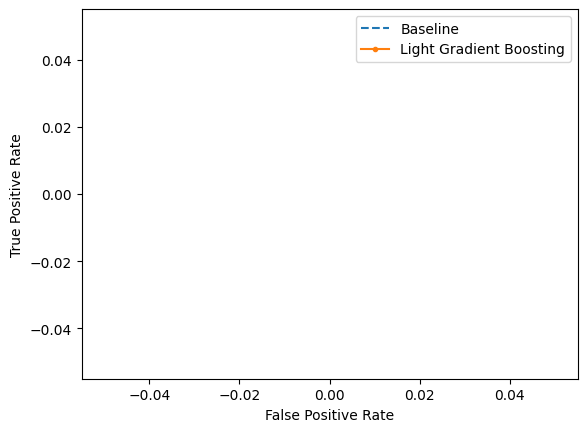

In [20]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model=GradientBoostingClassifier()
modelname='Light Gradient Boosting'

model.fit(X_train, y_train)

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_lgb=evaluate_model()

predfile_lgb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'lgb'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Light Gradient Descent - Default'

val_lgb=failure_samp[failure_samp['seg']=='val'][['cact']].reset_index()
val_lgb['lgb']=probs[:, 1].tolist()

#LGD=model_evaluation2()

RMSE: 0.012633
Actual       0.025075
Predicted    0.001484
dtype: float64
Actual       13278.0
Predicted      786.0
dtype: float64
Actual       0.00000
Predicted    0.00016
dtype: float64
Actual        0.0
Predicted    93.0
dtype: float64
Confusion matrix : 
 [[516119    130]
 [ 12622    656]]
Confusion matrix : 
 [[516249      0]
 [     0  13278]]
Confusion matrix : 
 [[582655     93]
 [     0      0]]
Confusion matrix : 
 [[582748      0]
 [     0      0]]
Baseline: ROC AUC=nan
Xgboost: ROC AUC=nan


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


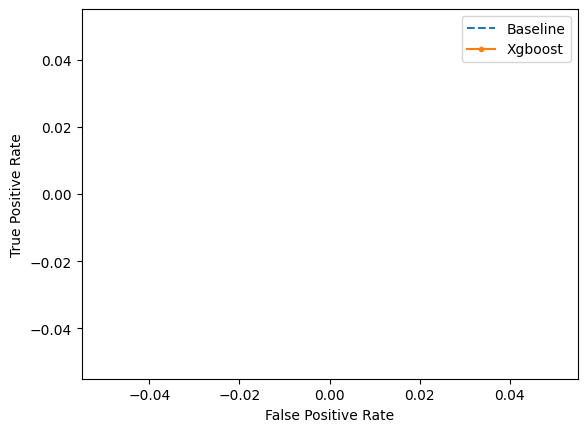

In [21]:
# 7) XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

model= XGBClassifier()
modelname='Xgboost'

model.fit(X_train,y_train)
preds=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_xgb=evaluate_model()

predfile_xgb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'xgb'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='XGBoost - Default'

val_xgb=failure_samp[failure_samp['seg']=='val'][['cact', 'y']].reset_index()
val_xgb['xgb']=probs[:, 1].tolist()

#XGB=model_evaluation2()

In [22]:
predfile_xgb_nodup=val_xgb.drop_duplicates(subset='cact', keep='first')
predfile_lgb_nodup=val_lgb.drop_duplicates(subset='cact', keep='first')

predfile_xgb_lgb=pd.merge(predfile_xgb_nodup, predfile_lgb_nodup, on='cact', how='inner')
predfile_xgb_lgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582748 entries, 0 to 582747
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   index_x  582748 non-null  int64  
 1   cact     582748 non-null  float64
 2   y        582748 non-null  float64
 3   xgb      582748 non-null  float64
 4   index_y  582748 non-null  int64  
 5   lgb      582748 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 26.7 MB


In [23]:
num_bins=20
labels=list(range(20, 0, -1))
labels

[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [24]:
num_bins=20
labels=list(range(20, 0, -1))

predfile_xgb_lgb['lgb_xgb']=predfile_xgb_lgb['lgb']*predfile_xgb_lgb['xgb']*100
predfile_xgb_lgb['lgb_xgb2']=(predfile_xgb_lgb['lgb']+predfile_xgb_lgb['xgb'])/2
predfile_xgb_lgb['lgb_xgb3']=np.sqrt(predfile_xgb_lgb['lgb']*predfile_xgb_lgb['xgb'])
predfile_xgb_lgb['lgb_bin']=pd.qcut(predfile_xgb_lgb['lgb'], q=20, labels=labels)
predfile_xgb_lgb['xgb_bin']=pd.qcut(predfile_xgb_lgb['xgb'], q=20, labels=labels)
predfile_xgb_lgb['lgb_xgb_bin']=pd.qcut(predfile_xgb_lgb['lgb_xgb'], q=20, labels=labels)
predfile_xgb_lgb['lgb_xgb_bin2']=pd.qcut(predfile_xgb_lgb['lgb_xgb2'], q=20, labels=labels)
predfile_xgb_lgb['lgb_xgb_bin3']=pd.qcut(predfile_xgb_lgb['lgb_xgb3'], q=20, labels=labels)

In [25]:
# extract new enroll since 2025/08/11
# notice we use 2025-02-01 as the cutoff data for enrollment
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-09-07';

    SELECT 
            ZOBJTID as cact,
            max(to_date(ZUDATE___T))    as last_enroll_date,
            min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_enroll_recency, 
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as enroll_cnt_lastyear,
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as enroll_cnt_last2years 
        FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUENEW = 'EBIL'
            and to_date(ZUDATE___T) > cutoff_date
        group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 
    
new_enroll=pd.DataFrame(ret)
new_enroll.columns=['cact', 'past_enroll_date', 'past_enroll_recency', 'enroll_cnt_lastyear', 'enroll_cnt_last2years']
new_enroll.info()
new_enroll.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5096 entries, 0 to 5095
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cact                   5096 non-null   object
 1   past_enroll_date       5096 non-null   object
 2   past_enroll_recency    5096 non-null   int64 
 3   enroll_cnt_lastyear    5096 non-null   int64 
 4   enroll_cnt_last2years  5096 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 199.2+ KB


,cact,past_enroll_date,past_enroll_recency,enroll_cnt_lastyear,enroll_cnt_last2years
0,600001502597,2025-09-08,-1,1,1
1,700000982875,2025-09-08,-1,1,1
2,700001008844,2025-09-08,-1,1,1
3,700001818489,2025-09-08,-1,1,1
4,700002664312,2025-09-09,-2,1,1


In [26]:
new_enroll['cact']=pd.to_numeric(new_enroll['cact'], errors='coerce')
new_enroll.drop_duplicates(subset='cact', keep='first', inplace=True)

In [27]:
pred_file_val=pd.merge(predfile_xgb_lgb, new_enroll.assign(y2=1), on='cact', how='left')
pred_file_val['y2'].fillna(0, inplace=True)

/var/tmp/ipykernel_7632/1830359806.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pred_file_val['y2'].fillna(0, inplace=True)


/var/tmp/ipykernel_7632/444325760.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/tmp/ipykernel_7632/444325760.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



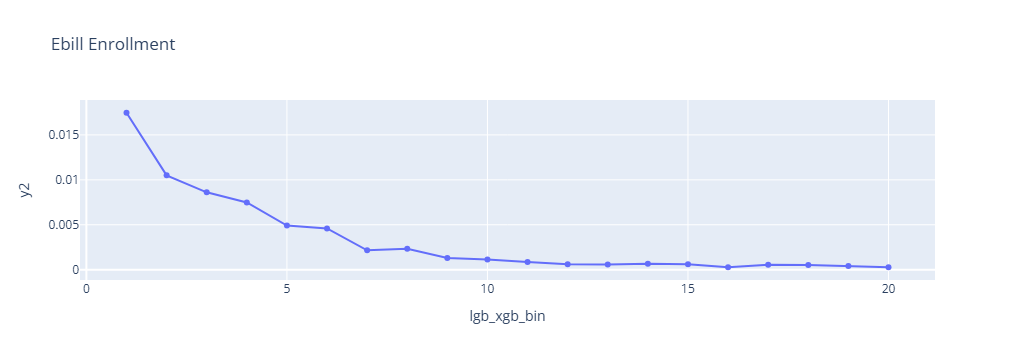

/var/tmp/ipykernel_7632/444325760.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/tmp/ipykernel_7632/444325760.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



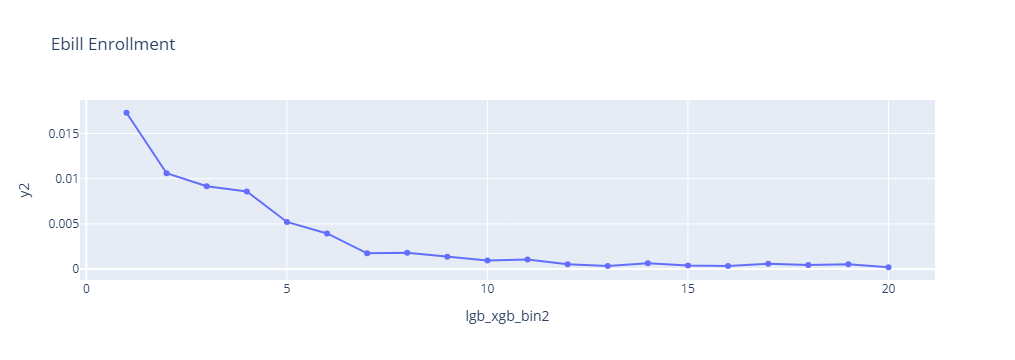

   lgb_xgb_bin3        y2
0            20  0.000275
1            19  0.000412
2            18  0.000515
3            17  0.000549
4            16  0.000275
5            15  0.000618
6            14  0.000652
7            13  0.000583
8            12  0.000618
9            11  0.000858
10           10  0.001133
11            9  0.001304
12            8  0.002334
13            7  0.002162
14            6  0.004599
15            5  0.004908
16            4  0.007482
17            3  0.008614
18            2  0.010502
19            1  0.017469


/var/tmp/ipykernel_7632/444325760.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



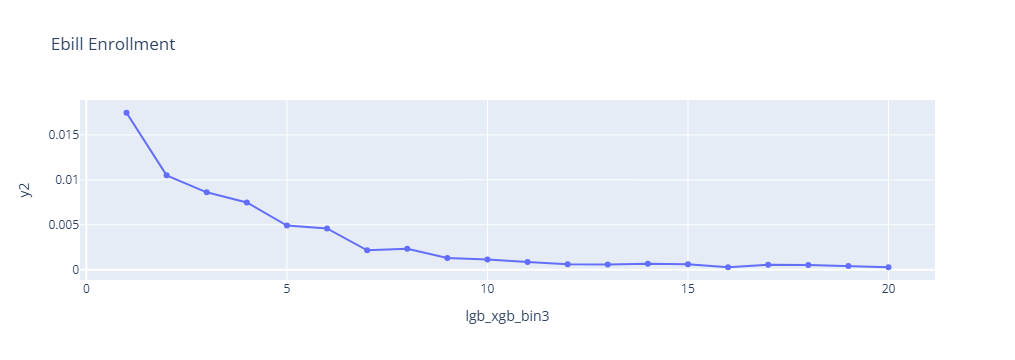

In [76]:
pred_file_val.groupby('lgb_xgb_bin')['y2'].mean()
forline=pred_file_val.groupby('lgb_xgb_bin')['y2'].mean().reset_index()
fig = px.line(forline, x='lgb_xgb_bin', y='y2', title='Ebill Enrollment', markers=True)
fig.show()

pred_file_val.groupby('lgb_xgb_bin2')['y2'].mean()
forline=pred_file_val.groupby('lgb_xgb_bin2')['y2'].mean().reset_index()
fig = px.line(forline, x='lgb_xgb_bin2', y='y2', title='Ebill Enrollment', markers=True)
fig.show()

forline=pred_file_val.groupby('lgb_xgb_bin3')['y2'].mean().reset_index()
print(forline)
fig = px.line(forline, x='lgb_xgb_bin3', y='y2', title='Ebill Enrollment', markers=True)
fig.show()

In [31]:
pred_file_val.columns.tolist()

['index_x',
 'cact',
 'y',
 'xgb',
 'index_y',
 'lgb',
 'lgb_xgb',
 'lgb_xgb2',
 'lgb_xgb3',
 'lgb_bin',
 'xgb_bin',
 'lgb_xgb_bin',
 'lgb_xgb_bin2',
 'lgb_xgb_bin3',
 'past_enroll_date',
 'past_enroll_recency',
 'enroll_cnt_lastyear',
 'enroll_cnt_last2years',
 'y2']

In [77]:
deploy_file=pred_file_val[['cact', 'lgb_xgb3']]
deploy_file.rename(columns={'lgb_xgb3': 'enroll_score'}, inplace=True)
deploy_file.sort_values(by='enroll_score', ascending=False, inplace=True)
deploy_file['dummy']=1
deploy_file['score_rank']=deploy_file['dummy'].cumsum()
deploy_file['score_tier']=(deploy_file['score_rank']/len(deploy_file))*100
deploy_file['score_tier']=deploy_file['score_tier'].astype('int')
deploy_file.drop('dummy', axis=1, inplace=True)
deploy_file.info()                    

<class 'pandas.core.frame.DataFrame'>
Index: 582748 entries, 136148 to 160669
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   cact          582748 non-null  float64
 1   enroll_score  582748 non-null  float64
 2   score_rank    582748 non-null  int64  
 3   score_tier    582748 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 22.2 MB


/var/tmp/ipykernel_7632/2553879984.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/tmp/ipykernel_7632/2553879984.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/tmp/ipykernel_7632/2553879984.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/tmp/ipykernel_7632/2553879984.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from 

In [78]:
deploy_file.groupby('score_tier')['score_rank'].mean()

score_tier
0        2914.0
1        8741.0
2       14568.5
3       20396.0
4       26223.5
         ...   
96     562352.0
97     568179.5
98     574007.0
99     579834.0
100    582748.0
Name: score_rank, Length: 101, dtype: float64

In [79]:
deploy_file['score_rank'].describe()

count    582748.000000
mean     291374.500000
std      168225.001672
min           1.000000
25%      145687.750000
50%      291374.500000
75%      437061.250000
max      582748.000000
Name: score_rank, dtype: float64

In [80]:
deploy_file.head()

,cact,enroll_score,score_rank,score_tier
136148,7.002139e+11,0.718389,1,0
399729,7.006709e+11,0.512504,2,0
357993,7.005813e+11,0.465602,3,0
564254,7.009930e+11,0.393246,4,0
566777,7.009944e+11,0.393198,5,0


In [81]:
#deploy_file.to_csv(str(path_name)+str('/deploy_file_20250908')+str('.csv'), index=False)

In [82]:
# merge with opt out data
#deploy_file=pd.read_csv(str(path_name)+str('/deploy_file_20250908')+str('.csv'))
past_enroll=pd.read_csv(str(path_name)+str('/past_enroll.csv'))
past_optout=pd.read_csv(str(path_name)+str('/past_optout.csv'))
past_optout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894420 entries, 0 to 894419
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   894420 non-null  int64 
 1   latest_optout_date     894420 non-null  object
 2   last_optout_recency    894420 non-null  int64 
 3   optout_cnt_total       894420 non-null  int64 
 4   optout_cnt_lastyear    894420 non-null  int64 
 5   optout_cnt_last2years  894420 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 40.9+ MB


In [83]:
deploy_file=pd.merge(deploy_file, past_optout, on='cact', how='left')
deploy_file=pd.merge(deploy_file, past_enroll, on='cact', how='left')
deploy_file.columns.tolist()

['cact',
 'enroll_score',
 'score_rank',
 'score_tier',
 'latest_optout_date',
 'last_optout_recency',
 'optout_cnt_total',
 'optout_cnt_lastyear',
 'optout_cnt_last2years',
 'past_enroll_date',
 'past_enroll_recency',
 'enroll_cnt_total',
 'enroll_cnt_lastyear',
 'enroll_cnt_last2years']

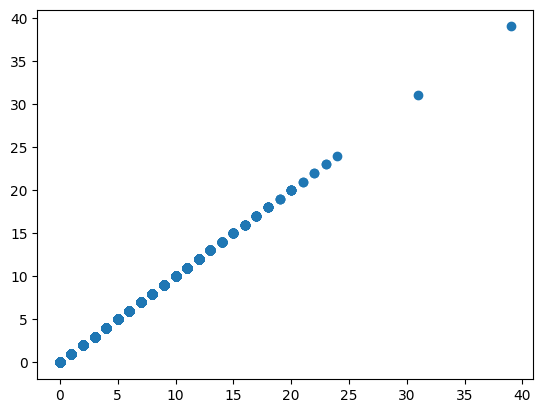

In [84]:
plt.scatter(deploy_file['optout_cnt_last2years'], deploy_file['enroll_cnt_last2years'])

In [85]:
deploy_file.head(100)

,cact,enroll_score,score_rank,score_tier,latest_optout_date,last_optout_recency,optout_cnt_total,optout_cnt_lastyear,optout_cnt_last2years,past_enroll_date,past_enroll_recency,enroll_cnt_total,enroll_cnt_lastyear,enroll_cnt_last2years
0,7.002139e+11,0.718389,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.006709e+11,0.512504,2,0,2025-03-28,164.0,1.0,1.0,1.0,2025-03-28,164.0,1.0,1.0,1.0
2,7.005813e+11,0.465602,3,0,2025-08-13,26.0,1.0,1.0,1.0,2025-08-13,26.0,1.0,1.0,1.0
3,7.009930e+11,0.393246,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.009944e+11,0.393198,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7.009940e+11,0.308236,96,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,7.009416e+11,0.307495,97,0,2025-05-20,111.0,1.0,1.0,1.0,2025-05-20,111.0,1.0,1.0,1.0
97,7.009956e+11,0.306779,98,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,7.009943e+11,0.306646,99,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
deploy_file.groupby('score_tier')[['enroll_score', 'score_rank']].mean()

,enroll_score,score_rank
score_tier,,
0,0.218347,2914.0
1,0.169740,8741.0
2,0.133586,14568.5
3,0.113730,20396.0
4,0.099138,26223.5
...,...,...
96,0.001769,562352.0
97,0.001660,568179.5
98,0.001508,574007.0


In [87]:
deploy_file=deploy_file[['cact',
 'enroll_score',
 'score_rank',
 'score_tier',
 'latest_optout_date',
 'last_optout_recency',
 'optout_cnt_total',
 'optout_cnt_lastyear',
 'optout_cnt_last2years']]

In [88]:
deploy_file.to_csv(str(path_name)+str('/deploy_file_20250908')+str('.csv'), index=False)